## **Import Library**

In [1]:
!pip install --upgrade pip -q
!pip install -q -U keras-nlp
!pip install -q rouge-score pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# GABUNGAN SEL 2 dan 11
print("Mengimpor library...")

# Impor library utama (dari Sel 2)
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import re
import os
import time

# Impor untuk pemrosesan data (dari Sel 2)
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

# Impor untuk evaluasi (dari Sel 2)
from rouge_score import rouge_scorer

# Mount Google Drive (dari Sel 2)
from google.colab import drive
drive.mount('/content/drive')

# Impor Keras & Keras-NLP (dari Sel 11)
import keras
import keras_nlp

print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")
print("Impor selesai.")

Mengimpor library...
Mounted at /content/drive
Keras version: 3.10.0
KerasNLP version: 0.23.0
Impor selesai.


## **Load Data**

In [48]:
# --- PENTING: Ubah path ini sesuai lokasi file Anda di GDrive ---

FILE_PATH = '/content/drive/MyDrive/nlp-deepL/qna-psychiatrist.parquet'

# Baca file parquet
try:
    df = pd.read_parquet(FILE_PATH)
except Exception as e:
    print(f"Error: {e}")
    print("\nPastikan FILE_PATH di atas sudah benar.")

# Ganti nama kolom untuk kejelasan
df = df.rename(columns={'User': 'question', 'Psikiater': 'answer'})

# Hapus baris yang mungkin kosong
df = df.dropna(subset=['question', 'answer'])

print(f"Dataset berhasil dimuat. Jumlah data: {len(df)}")
df.head()

Dataset berhasil dimuat. Jumlah data: 6477


,question,answer
0,"Dok, gue kayaknya stres banget nih gara-gara t...","Oke, ceritain dulu apa yang bikin kamu merasa ..."
1,"Gue bingung banget, tugas-tugas ini nggak ada ...","Hmm, kamu coba udah bikin jadwal atau planning..."
2,"Iya, udah sih, tapi tetep aja kayak nggak cuku...",Mungkin kamu bisa coba bagi waktu lebih detail...
3,"Masalahnya, gue juga punya kegiatan organisasi...","Oh, kamu aktif di organisasi juga ya. Berarti ..."
4,"Iya, bener banget. Kadang gue ngerasa nggak bi...",Pernah coba delegasiin tugas organisasi ke ang...


## **Preprocess**

kami tidak menggunakan stopword standard dari library sastrawi, namun menggunakan bantuan LLM untuk menyusun kamus stopword dan normalisasinya, berdasarkan dataset yang digunakan

### stopword

In [4]:
# Daftar ini HANYA berisi kata-kata yang 100% noise
# (sapaan, filler, dan beberapa kata sambung yg sangat umum)
custom_stopwords_only = [
    # Sapaan & Penutup (Noise untuk model)
    'dok', 'dokter', 'halo', 'hai', 'permisi',
    'selamat', 'pagi', 'siang', 'sore', 'malam',
    'terima', 'kasih', 'makasih', 'maaf',
    'bye',

    # Kata sambung/preposisi yg SANGAT umum
    # Kita harus hati-hati di sini. 'di', 'ke', 'dari' mungkin penting.
    'adalah', 'ialah', 'yaitu', 'yakni',
    'pada', 'kepada', 'oleh',
    'namun', 'akan', 'dan', 'atau',

    # Filler words (Kata-kata pengisi yang aman dihapus)
    'sih', 'deh', 'dong', 'kok', 'nih', 'tuh', 'ya',
    'loh', 'lho',
    'eh',
    'hm', 'hmm', 'hmmm',
    'wah',

    # KATA-KATA YANG TIDAK BOLEH DIHAPUS (JANGAN TAMBAHKAN INI):
    # 'saya', 'kamu', 'dia', 'mereka'
    # 'bagaimana', 'kenapa', 'apa', 'dimana', 'kapan'
    # 'lagi', 'sudah', 'belum', 'sedang'
    # 'yang', 'untuk', 'dengan', 'ini', 'itu'
]

# --- 2. Buat 'set' dari daftar kustom ---
stopword_set = set(custom_stopwords_only)

print(f"Total stopword: {len(stopword_set)}")

Total stopword: 40


### normalization dictionary

In [5]:
# Kamus normalisasi yang jauh lebih lengkap
normalization_dict = {
    # --- Pronomina (Kata Ganti) ---
    'gue': 'saya', 'gw': 'saya', 'gua': 'saya', 'sy': 'saya', 'aku': 'saya', 'q': 'saya',
    'lo': 'kamu', 'lu': 'kamu', 'loe': 'kamu', 'km': 'kamu', 'anda': 'kamu',
    'dia': 'dia', 'dy': 'dia',
    'kita': 'kita', 'kami': 'kami',
    'kalian': 'kalian',
    'mereka': 'mereka', 'mrk': 'mereka',

    # --- Kata Tanya ---
    'gimana': 'bagaimana', 'gmn': 'bagaimana',
    'kenapa': 'kenapa', 'knp': 'kenapa',
    'apa': 'apa', 'ap': 'apa', 'apaa': 'apa',
    'kapan': 'kapan', 'kpn': 'kapan',
    'dimana': 'di mana', 'dmn': 'di mana',
    'siapa': 'siapa', 'spa': 'siapa',
    'brp': 'berapa',

    # --- Kata Sambung & Preposisi ---
    'yg': 'yang', 'utk': 'untuk', 'dgn': 'dengan', 'dg': 'dengan',
    'dr': 'dari', 'kalo': 'kalau', 'klo': 'kalau', 'kl': 'kalau',
    'krn': 'karena', 'krna': 'karena',
    'karna': 'karena', 'sbb': 'sebagai berikut',
    'sampe': 'sampai', 'ampe': 'sampai',
    'sm': 'sama', 'ama': 'sama',
    'trus': 'terus', 'trs': 'terus',
    'sblm': 'sebelum', 'sblmnya': 'sebelumnya',
    'stlh': 'setelah',
    'tp': 'tapi', 'tpi': 'tapi',
    'dan': 'dan', 'dn': 'dan',

    # --- Kata Negasi & Afirmasi ---
    'gak': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'gk': 'tidak', 'tdk': 'tidak', 'engga': 'tidak', 'enggak': 'tidak',
    'bukan': 'bukan', 'bkn': 'bukan',
    'iya': 'iya', 'y': 'ya',
    'bener': 'benar', 'bnr': 'benar',

    # --- Singkatan Umum ---
    'aja': 'saja', 'sja': 'saja',
    'lg': 'lagi', 'lgi': 'lagi',
    'jg': 'juga', 'jga': 'juga',
    'br': 'baru', 'bru': 'baru',
    'bs': 'bisa', 'bisaa': 'bisa',
    'blm': 'belum', 'blom': 'belum', 'blon': 'belum',
    'sdh': 'sudah', 'udah': 'sudah', 'dah': 'sudah',
    'skrg': 'sekarang', 'skrng': 'sekarang',
    'jd': 'jadi', 'jdi': 'jadi',
    'dpt': 'dapat', 'dapet': 'dapat',
    'kyk': 'seperti', 'kayak': 'seperti', 'kaya': 'seperti',
    'gini': 'begini', 'gni': 'begini',
    'gitu': 'begitu', 'gtu': 'begitu',
    'bgt': 'banget', 'bngt': 'banget', 'bangettt': 'banget', 'bangett': 'banget',
    'gt': 'begitu',
    'org': 'orang', 'orng': 'orang',
    'tmn': 'teman', 'temen': 'teman', 'temen2': 'teman-teman',
    'byk': 'banyak', 'bnyk': 'banyak',
    'bbrp': 'beberapa',
    'sbg': 'sebagai',
    'sbnrnya': 'sebenarnya', 'sbnrny': 'sebenarnya',
    'emg': 'memang',
    'emang': 'memang',
    'bgmn': 'bagaimana',
    'thn': 'tahun', 'bln': 'bulan',
    'smlm': 'semalam', 'kmrn': 'kemarin', 'bsk': 'besok',
    'bknny': 'bukannya', 'bukannya': 'bukannya',
    'dlm': 'dalam', 'dlu': 'dulu', 'dulu': 'dulu',
    'hp': 'ponsel', # atau biarkan 'hp'

    # --- Kata Kerja Slang ---
    'ngomong': 'berbicara', 'ngmg': 'berbicara', 'bilang': 'berkata', 'blg': 'berkata',
    'ngerjain': 'mengerjakan', 'ngerjainnya': 'mengerjakannya',
    'ngelakuin': 'melakukan',
    'ngerasa': 'merasa',
    'ngalamin': 'mengalami',
    'ngerti': 'mengerti', 'ngertiin': 'mengerti',
    'ngeliat': 'melihat', 'liat': 'lihat',
    'mikir': 'berpikir', 'mikirin': 'memikirkan',
    'bikinin': 'membuatkan', 'bikin': 'membuat',
    'buat': 'untuk', # 'buat' bisa berarti 'membuat' atau 'untuk', kita pilih 'untuk' yg lebih umum
    'cariin': 'carikan', 'nyari': 'mencari',
    'kasih': 'beri', 'ngasih': 'memberi',
    'tau': 'tahu',
    'masukin': 'memasukkan',
    'nunggu': 'menunggu', 'nungguin': 'menunggu',
    'nyoba': 'mencoba', 'nyobain': 'mencoba',
    'nanya': 'bertanya',
    'jawab': 'jawab', 'jwb': 'jawab',
    'scrol': 'scroll', # biarkan, atau normalisasi ke 'gulir'

    # --- Kata Sifat/Keterangan Slang ---
    'males': 'malas', 'mager': 'malas gerak',
    'capek': 'lelah', 'capeknya': 'lelahnya', 'cape': 'lelah',
    'gampang': 'mudah', 'gmpg': 'mudah',
    'susah': 'sulit',
    'pede': 'percaya diri',
    'mending': 'lebih baik', 'mnding': 'lebih baik',
    'bgs': 'bagus',
    'cepet': 'cepat', 'cpt': 'cepat',
    'knp': 'kenapa',

    # --- Konteks Spesifik Dataset ---
    'dok': 'dokter',
    'stres': 'stres', 'stress': 'stres', # Menyeragamkan ejaan
    'cemas': 'cemas', 'anxiety': 'cemas',
    'overwhelmed': 'kewalahan',
    'overthinking': 'terlalu banyak berpikir',
    'insecure': 'tidak percaya diri', 'insecur': 'tidak percaya diri',
    'deadline': 'tenggat waktu', 'deadlinenya': 'tenggat waktunya',
    'online': 'daring',
    'offline': 'luring',
    'chat': 'obrolan',
    'pls': 'tolong', 'please': 'tolong',
    'thanks': 'terima kasih', 'thank': 'terima kasih', 'thx': 'terima kasih', 'makasih': 'terima kasih',
    'sorry': 'maaf', 'maap': 'maaf',
    'ok': 'oke',
    'support': 'dukungan',
    'mental': 'mental',
    'prokrastinasi': 'prokrastinasi',
    'burnout': 'burnout', # Istilah ini sudah umum
    'reward': 'penghargaan',
    'planning': 'rencana', 'planni': 'rencana',
    'handle': 'menangani', 'handl': 'menangani',
    'manage': 'mengelola', 'manajemen': 'manajemen',
    'feedback': 'umpan balik',
    'mindfulness': 'mindfulness', # Istilah umum
    'to-do list': 'daftar tugas',
}

### cleaning func

In [6]:
def advanced_clean_text(text):
    # 1. Lowercasing
    text = text.lower()

    # 2. Normalisasi Slang/Kata Tidak Baku
    words = text.split()
    normalized_words = []
    for word in words:
        # Cek jika kata ada di kamus, jika ya, ganti. Jika tidak, biarkan.
        normalized_words.append(normalization_dict.get(word, word))
    text = " ".join(normalized_words)

    # 3. Hapus Punctuation & Angka
    # Hanya simpan huruf dan spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Stopword Removal
    words = text.split()

    # Hanya simpan kata yang TIDAK ada di stopword_set
    cleaned_words = [word for word in words if word not in stopword_set]
    text = " ".join(cleaned_words)

    # 5. Hapus Spasi Berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Tes fungsi dengan kamus baru ---
test_sentence = "Dok, gue tuh lg stres bgt gara-gara tugas kuliah yg numpuk. Gmn ya solusinya? Sbnrnya gw jg males."
cleaned = advanced_clean_text(test_sentence)

print(f"\nKALIMAT ASLI:\n{test_sentence}")
print(f"\nHASIL BERSIH (dengan kamus lengkap):\n{cleaned}")


KALIMAT ASLI:
Dok, gue tuh lg stres bgt gara-gara tugas kuliah yg numpuk. Gmn ya solusinya? Sbnrnya gw jg males.

HASIL BERSIH (dengan kamus lengkap):
saya lagi stres banget garagara tugas kuliah yang numpuk bagaimana solusinya sebenarnya saya juga males


### parameter

In [13]:
# --- Hyperparameter Model ---

# Ukuran kosakata (vocabulary)
# Berdasarkan dataset 6k Anda, 10000 sudah cukup.
VOCAB_SIZE = 10000

# Panjang maksimum sekuens (kalimat)
# Anda bisa analisis panjang kalimat, tapi 128 biasanya aman.
MAX_LENGTH = 128

# Parameter Arsitektur Transformer
NUM_LAYERS = 4  # Jumlah Encoder/Decoder layers (N)
D_MODEL = 128   # Dimensi embedding (ukuran vektor kata)
DFF = 512       # Dimensi Feed-Forward Network
NUM_HEADS = 8   # Jumlah attention heads
DROPOUT_RATE = 0.1

# --- Hyperparameter Training ---
BATCH_SIZE = 64
EPOCHS = 30

### data cleaning dengan cleaning function diatas

In [61]:
# 1. Terapkan pembersihan canggih
df['question_clean'] = df['question'].apply(advanced_clean_text)
df['answer_clean'] = df['answer'].apply(advanced_clean_text)

# 2. Hapus baris yang mungkin menjadi kosong
df = df[df['question_clean'].str.len() > 0]
df = df[df['answer_clean'].str.len() > 0]
df = df.reset_index(drop=True)

print(f"Baris tersisa setelah cleaning: {len(df)}")

# 3. Buat TIGA kolom teks (INI KUNCINYA)
START_TOKEN = "[START]"
END_TOKEN = "[END]"

# Input Encoder: [START] pertanyaan [END]
df['encoder_input_text'] = df['question_clean'].apply(lambda x: f"{START_TOKEN} {x} {END_TOKEN}")

# Input Decoder: [START] jawaban [END]
df['decoder_input_text'] = df['answer_clean'].apply(lambda x: f"{START_TOKEN} {x} {END_TOKEN}")

# Target Decoder: jawaban [END] (TANPA [START])
df['decoder_target_text'] = df['answer_clean'].apply(lambda x: f"{x} {END_TOKEN}")


# 4. Buat dan 'adapt' tokenizer
# Corpus harus berisi SEMUA teks yang mungkin
corpus = (
    df['encoder_input_text'].tolist() +
    df['decoder_input_text'].tolist() +
    df['decoder_target_text'].tolist()
)

tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    standardize=None,
    output_sequence_length=MAX_LENGTH
)

tokenizer.adapt(corpus)
print(f"Ukuran Kosakata Aktual: {tokenizer.vocabulary_size()}")

Baris tersisa setelah cleaning: 6426
Ukuran Kosakata Aktual: 2646


### Split data

- training 80%
- validasi 10%
- test 10%

In [9]:
# --- Tahap 1 (REVISI): Split Data 80/10/10 ---

# 1. Tokenisasi Teks dan KONVERSI KE NUMPY
encoder_input_tokens = tokenizer(df['encoder_input_text']).numpy()
decoder_input_tokens = tokenizer(df['decoder_input_text']).numpy()
decoder_target_tokens = tokenizer(df['decoder_target_text']).numpy()

print("Data teks berhasil diubah menjadi token angka (NumPy array).")

# 2. Split Pertama: 80% Train vs 20% (Temp)
# Kita ambil 80% data untuk training
(
    encoder_input_train,  # 80%
    encoder_input_temp,   # 20%
    decoder_input_train,  # 80%
    decoder_input_temp,   # 20%
    decoder_target_train, # 80%
    decoder_target_temp,  # 20%
) = train_test_split(
    encoder_input_tokens,
    decoder_input_tokens,
    decoder_target_tokens,
    test_size=0.2,       # 20% untuk 'temp' (Val + Test)
    random_state=42,
)

# 3. Split Kedua: 10% Val vs 10% Test
# Kita bagi 'temp' (20%) menjadi dua, masing-masing 10% dari total
(
    encoder_input_val,    # 10%
    encoder_input_test,   # 10%
    decoder_input_val,    # 10%
    decoder_input_test,   # 10%
    decoder_target_val,   # 10%
    decoder_target_test,  # 10%
) = train_test_split(
    encoder_input_temp,   # Input 20%
    decoder_input_temp,
    decoder_target_temp,
    test_size=0.5,        # Bagi 20% menjadi 50% (10% total) dan 50% (10% total)
    random_state=42,
)

print(f"\nTotal data Train: {len(encoder_input_train)}")
print(f"Total data Validation: {len(encoder_input_val)}")
print(f"Total data Test: {len(encoder_input_test)}")


# 4. Buat tf.data.Dataset
# (Kita akan membuat 3 dataset sekarang)

def format_dataset(enc_in, dec_in, dec_target):
    return ({"encoder_input": enc_in, "decoder_input": dec_in}, dec_target)

# --- Dataset untuk Training ---
train_dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_input_train, decoder_input_train, decoder_target_train)
)
train_dataset = train_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BATCH_SIZE * 10).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Dataset untuk Validasi ---
# (Digunakan oleh model.fit untuk val_loss)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_input_val, decoder_input_val, decoder_target_val)
)
val_dataset = val_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Dataset untuk Test ---
# (Disimpan untuk evaluasi ROUGE di akhir)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_input_test, decoder_input_test, decoder_target_test)
)
test_dataset = test_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# 5. Inspeksi Dataset Training
print("\nStruktur elemen dataset (Input, Target):")
print(train_dataset.element_spec)

Data teks berhasil diubah menjadi token angka (NumPy array).

Total data Train: 5140
Total data Validation: 643
Total data Test: 643

Struktur elemen dataset (Input, Target):
({'encoder_input': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'decoder_input': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 128), dtype=tf.int64, name=None))


In [62]:
# Cell #VSC-447e0fca - HARUS dijalankan dulu!

print("="*70)
print("REKONSTRUKSI test_df DARI SPLIT YANG ADA")
print("="*70)

from sklearn.model_selection import train_test_split
import numpy as np

# Buat dummy array dengan panjang sama dengan df
dummy_indices = np.arange(len(df))

# Split pertama: 80% train, 20% temp (SAMA dengan split tokenisasi Anda)
_, temp_indices = train_test_split(
    dummy_indices,
    test_size=0.2,
    random_state=42  # ⚠️ HARUS SAMA
)

# Split kedua: 10% val, 10% test (SAMA dengan split tokenisasi Anda)
_, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,  # 50% dari 20% = 10% total
    random_state=42  # ⚠️ HARUS SAMA
)

# ✅ Ambil data dari df menggunakan indeks yang sama dengan test set
test_df = df.iloc[test_indices].reset_index(drop=True)

print(f"\n✅ test_df berhasil direkonstruksi:")
print(f"  • Total rows: {len(test_df)}")
print(f"  • Sesuai dengan encoder_input_test: {len(test_df) == len(encoder_input_test)}")
print(f"  • Kolom tersedia: {test_df.columns.tolist()}")

# Validasi: Cek apakah kolom yang dibutuhkan ada
required_columns = ['question', 'answer_clean']
missing_columns = [col for col in required_columns if col not in test_df.columns]

if missing_columns:
    print(f"\n⚠️  WARNING: Kolom berikut tidak ditemukan: {missing_columns}")
    print(f"  Kolom yang tersedia: {test_df.columns.tolist()}")
else:
    print(f"\n✅ Semua kolom yang dibutuhkan tersedia!")

# Cek sampel pertama
print(f"\n🔍 Sample test_df[0]:")
print(f"  Question: {test_df.iloc[0]['question'][:80]}...")
if 'answer_clean' in test_df.columns:
    print(f"  Answer: {test_df.iloc[0]['answer_clean'][:80]}...")

# Cek apakah ada NaN
nan_count = test_df[['question', 'answer_clean']].isna().sum()
print(f"\n📊 Cek data kosong:")
print(f"  • question NaN: {nan_count['question']}")
print(f"  • answer_clean NaN: {nan_count['answer_clean']}")

print("="*70)

REKONSTRUKSI test_df DARI SPLIT YANG ADA

✅ test_df berhasil direkonstruksi:
  • Total rows: 643
  • Sesuai dengan encoder_input_test: True
  • Kolom tersedia: ['question', 'answer', 'question_clean', 'answer_clean', 'encoder_input_text', 'decoder_input_text', 'decoder_target_text']

✅ Semua kolom yang dibutuhkan tersedia!

🔍 Sample test_df[0]:
  Question: Makasih banyak lagi, Dok!...
  Answer: samasama semoga sukses...

📊 Cek data kosong:
  • question NaN: 0
  • answer_clean NaN: 0


## **Model Transformer**


### arsitektur model

In [10]:
import tensorflow as tf
import keras_nlp
from tensorflow import keras

# Dapatkan ukuran kosakata (pastikan tokenizer sudah di-adapt)
vocab_size = tokenizer.vocabulary_size()

# --- 1. Tentukan Input untuk Model ---
encoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="encoder_input"
)
decoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="decoder_input"
)

# --- 2. Bagian ENCODER ---
encoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True, # Otomatis menangani padding mask
    name="encoder_embedding"
)
encoder_embedded = encoder_embedding_layer(encoder_input)

encoder_stack = keras.Sequential(
    [
        keras_nlp.layers.TransformerEncoder(
            intermediate_dim=DFF,
            num_heads=NUM_HEADS,
            dropout=DROPOUT_RATE,
            name=f"transformer_encoder_layer_{i}"
        )
        for i in range(NUM_LAYERS) # Ulangi sebanyak NUM_LAYERS
    ],
    name="encoder_stack"
)
encoder_output = encoder_stack(encoder_embedded)

# --- 3. Bagian DECODER ---
decoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True,
    name="decoder_embedding"
)
decoder_embedded = decoder_embedding_layer(decoder_input)

decoder_layers = [
    keras_nlp.layers.TransformerDecoder(
        intermediate_dim=DFF,
        num_heads=NUM_HEADS,
        dropout=DROPOUT_RATE,
        name=f"transformer_decoder_layer_{i}"
    )
    for i in range(NUM_LAYERS)
]

decoder_output = decoder_embedded
for layer in decoder_layers:
    decoder_output = layer(
        decoder_sequence=decoder_output,
        encoder_sequence=encoder_output
    )

# --- 4. Lapisan Output Akhir (PERBAIKAN DI SINI) ---
# Hapus activation="softmax". Biarkan default (linear) agar mengeluarkan LOGITS.
final_output = keras.layers.Dense(
    vocab_size,
    name="final_output"
)(decoder_output)

# --- 5. Rakit Model ---
transformer_model = keras.Model(
    inputs={
        "encoder_input": encoder_input,
        "decoder_input": decoder_input
    },
    outputs={
        "final_output": final_output
    }
)

# Tampilkan ringkasan arsitektur
print("--- Arsitektur Model (Diperbaiki) ---")
transformer_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_stack' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


--- Arsitektur Model (Diperbaiki) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 128) │    355,072 │ encoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 128) │    355,072 │ decoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_stack       │ (None, None, 128) │    793,088 │ encoder_embeddin… │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    264,576 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    264,576 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    264,576 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    264,576 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, None,      │    341,334 │ transformer_deco… │
│ (Dense)             │ 2646)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,902,870 (11.07 MB)

 Trainable params: 2,902,870 (11.07 MB)

 Non-trainable params: 0 (0.00 B)

### compile model

In [11]:
# 1. Definisikan Loss Function
def masked_loss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_unmasked = loss_fn(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_unmasked.dtype)
    loss_masked = loss_unmasked * mask
    return tf.reduce_sum(loss_masked) / tf.reduce_sum(mask)

# 2. Definisikan Metrik Akurasi
def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    correct_predictions = tf.cast(tf.equal(y_pred, y_true), "float32")
    mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, 0)), "float32")
    return tf.reduce_sum(correct_predictions * mask) / tf.reduce_sum(mask)

# 3. Compile Model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "final_output": masked_loss
    },
    metrics={
        "final_output": masked_accuracy
    }
)

print("\nModel berhasil di-compile ulang menggunakan nama layer 'final_output'.")
print("Silakan jalankan ulang sel Tahap 3 (Training).")

Mendiagnosis masalah: Keras mengharapkan nama layer ('final_output'), bukan kunci dictionary ('output').
Memperbaiki 'model.compile()'...

Model berhasil di-compile ulang menggunakan nama layer 'final_output'.
Silakan jalankan ulang sel Tahap 3 (Training).


## **Train**

### training model

In [14]:
print("Memulai pelatihan model dengan Early Stopping...")
print(f"Data Latih: {len(train_dataset)} batch ({len(encoder_input_train)} sampel)")
print(f"Data Validasi: {len(val_dataset)} batch ({len(encoder_input_val)} sampel)")
print(f"Epochs: {EPOCHS}")

# Setup Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Pantau validation loss
    patience=5,                   # Berhenti jika tidak ada perbaikan selama 5 epoch
    restore_best_weights=True,    # Kembalikan ke weights terbaik
    verbose=1
)

# Setup ModelCheckpoint (opsional, untuk backup)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_transformer_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Mulai training dengan callbacks
history = transformer_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint],  # ✅ Tambahkan callbacks
    verbose=1
)

print("\n--- Pelatihan Model Selesai ---")
print(f"Training berhenti di epoch: {len(history.history['loss'])}")

# Simpan weights final
transformer_model.save_weights('transformer_final_weights.weights.h5')
print("Model weights berhasil disimpan.")

Memulai pelatihan model dengan Early Stopping...
Data Latih: 81 batch (5140 sampel)
Data Validasi: 11 batch (643 sampel)
Epochs: 30
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 6.1017 - masked_accuracy: 0.1316
Epoch 1: val_loss improved from inf to 3.97830, saving model to best_transformer_model.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 559ms/step - loss: 6.0908 - masked_accuracy: 0.1324 - val_loss: 3.9783 - val_masked_accuracy: 0.3157
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.6722 - masked_accuracy: 0.3620
Epoch 2: val_loss improved from 3.97830 to 3.00719, saving model to best_transformer_model.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 3.6689 - masked_accuracy: 0.3624 - val_loss: 3.0072 - val_masked_accuracy: 0.4422
Epoch 3/30
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.7120 - masked_accuracy: 0.4950
Epoch 3: val_loss improved from 3.00719 to 2.48819, saving model to best_transformer_model.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━

### visualisasi hasil training


=== Membuat Visualisasi Hasil Training ===

Training Accuracy Key: masked_accuracy
Validation Accuracy Key: val_masked_accuracy



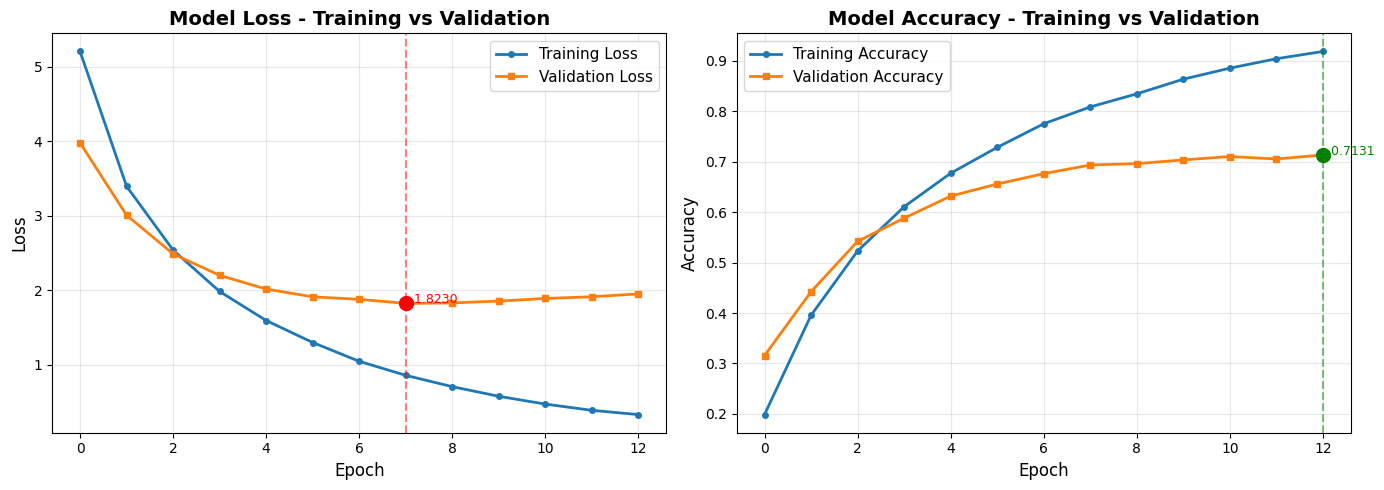

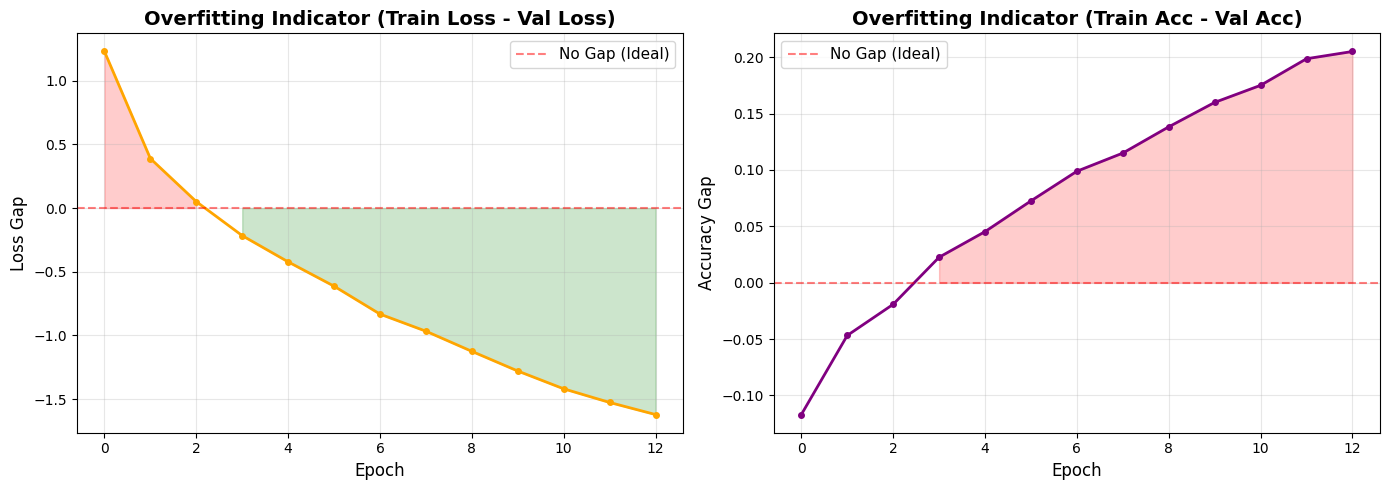


RINGKASAN HASIL TRAINING MODEL BASELINE

📊 LOSS:
  • Training Loss (Awal):    5.2066
  • Training Loss (Akhir):   0.3296
  • Validation Loss (Awal):  3.9783
  • Validation Loss (Akhir): 1.9502
  • Best Validation Loss:    1.8230 (Epoch 8)

🎯 ACCURACY:
  • Training Accuracy (Awal):    0.1987
  • Training Accuracy (Akhir):   0.9182
  • Validation Accuracy (Awal):  0.3157
  • Validation Accuracy (Akhir): 0.7131
  • Best Validation Accuracy:    0.7131 (Epoch 13)

📈 IMPROVEMENT:
  • Training Loss menurun:       93.67%
  • Validation Loss menurun:     50.98%
  • Training Accuracy meningkat: 362.00%
  • Validation Accuracy meningkat: 125.91%

⚠️  OVERFITTING CHECK:
  • Loss Gap (Akhir): -1.6207 - ⚠️  Kemungkinan UNDERFITTING
  • Accuracy Gap (Akhir): 0.2051 - ⚠️  Kemungkinan OVERFITTING

⏱️  TRAINING INFO:
  • Total Epochs Trained: 13
  • Batch Size: 64
  • Dataset Size: Train=5140, Val=643

Siap untuk evaluasi ROUGE pada test set!



In [19]:
# ============================================
# VISUALISASI HASIL TRAINING MODEL BASELINE
# ============================================

print("=== Membuat Visualisasi Hasil Training ===\n")

# Deteksi nama key metrik accuracy secara otomatis
accuracy_keys = [k for k in history.history.keys() if 'accuracy' in k.lower() and 'val' not in k]
val_accuracy_keys = [k for k in history.history.keys() if 'accuracy' in k.lower() and 'val' in k]

# Ambil key pertama yang ditemukan
train_acc_key = accuracy_keys[0] if accuracy_keys else None
val_acc_key = val_accuracy_keys[0] if val_accuracy_keys else None

print(f"Training Accuracy Key: {train_acc_key}")
print(f"Validation Accuracy Key: {val_acc_key}\n")

# --- 1. Plot Loss (Training vs Validation) ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
plt.title('Model Loss - Training vs Validation', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Tambahkan anotasi nilai terbaik
best_val_loss_epoch = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_epoch]
plt.axvline(x=best_val_loss_epoch, color='red', linestyle='--', alpha=0.5)
plt.scatter([best_val_loss_epoch], [best_val_loss], color='red', s=100, zorder=5)
plt.text(best_val_loss_epoch, best_val_loss, f'  {best_val_loss:.4f}', fontsize=9, color='red')

# --- 2. Plot Accuracy (Training vs Validation) ---
if train_acc_key and val_acc_key:
    plt.subplot(1, 2, 2)
    plt.plot(history.history[train_acc_key], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(history.history[val_acc_key], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    plt.title('Model Accuracy - Training vs Validation', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Tambahkan anotasi nilai terbaik
    best_val_acc_epoch = np.argmax(history.history[val_acc_key])
    best_val_acc = history.history[val_acc_key][best_val_acc_epoch]
    plt.axvline(x=best_val_acc_epoch, color='green', linestyle='--', alpha=0.5)
    plt.scatter([best_val_acc_epoch], [best_val_acc], color='green', s=100, zorder=5)
    plt.text(best_val_acc_epoch, best_val_acc, f'  {best_val_acc:.4f}', fontsize=9, color='green')

plt.tight_layout()
plt.show()

# --- 3. Plot Overfitting Analysis ---
if train_acc_key and val_acc_key:
    plt.figure(figsize=(14, 5))

    # Gap antara Training dan Validation Loss
    plt.subplot(1, 2, 1)
    loss_gap = np.array(history.history['loss']) - np.array(history.history['val_loss'])
    plt.plot(loss_gap, linewidth=2, marker='o', markersize=4, color='orange')
    plt.title('Overfitting Indicator (Train Loss - Val Loss)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Gap', fontsize=12)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap (Ideal)')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.fill_between(range(len(loss_gap)), loss_gap, 0, where=(loss_gap > 0), alpha=0.2, color='red')
    plt.fill_between(range(len(loss_gap)), loss_gap, 0, where=(loss_gap < 0), alpha=0.2, color='green')

    # Gap antara Training dan Validation Accuracy
    plt.subplot(1, 2, 2)
    acc_gap = np.array(history.history[train_acc_key]) - np.array(history.history[val_acc_key])
    plt.plot(acc_gap, linewidth=2, marker='o', markersize=4, color='purple')
    plt.title('Overfitting Indicator (Train Acc - Val Acc)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy Gap', fontsize=12)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap (Ideal)')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.fill_between(range(len(acc_gap)), acc_gap, 0, where=(acc_gap > 0), alpha=0.2, color='red')

    plt.tight_layout()
    plt.show()

# --- 4. Summary Statistics ---
print("\n" + "="*60)
print("RINGKASAN HASIL TRAINING MODEL BASELINE")
print("="*60)

print(f"\n📊 LOSS:")
print(f"  • Training Loss (Awal):    {history.history['loss'][0]:.4f}")
print(f"  • Training Loss (Akhir):   {history.history['loss'][-1]:.4f}")
print(f"  • Validation Loss (Awal):  {history.history['val_loss'][0]:.4f}")
print(f"  • Validation Loss (Akhir): {history.history['val_loss'][-1]:.4f}")
print(f"  • Best Validation Loss:    {best_val_loss:.4f} (Epoch {best_val_loss_epoch + 1})")

if train_acc_key and val_acc_key:
    print(f"\n🎯 ACCURACY:")
    print(f"  • Training Accuracy (Awal):    {history.history[train_acc_key][0]:.4f}")
    print(f"  • Training Accuracy (Akhir):   {history.history[train_acc_key][-1]:.4f}")
    print(f"  • Validation Accuracy (Awal):  {history.history[val_acc_key][0]:.4f}")
    print(f"  • Validation Accuracy (Akhir): {history.history[val_acc_key][-1]:.4f}")
    print(f"  • Best Validation Accuracy:    {best_val_acc:.4f} (Epoch {best_val_acc_epoch + 1})")

    print(f"\n📈 IMPROVEMENT:")
    train_loss_improvement = ((history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0]) * 100
    val_loss_improvement = ((history.history['val_loss'][0] - history.history['val_loss'][-1]) / history.history['val_loss'][0]) * 100
    train_acc_improvement = ((history.history[train_acc_key][-1] - history.history[train_acc_key][0]) / history.history[train_acc_key][0]) * 100
    val_acc_improvement = ((history.history[val_acc_key][-1] - history.history[val_acc_key][0]) / history.history[val_acc_key][0]) * 100

    print(f"  • Training Loss menurun:       {train_loss_improvement:.2f}%")
    print(f"  • Validation Loss menurun:     {val_loss_improvement:.2f}%")
    print(f"  • Training Accuracy meningkat: {train_acc_improvement:.2f}%")
    print(f"  • Validation Accuracy meningkat: {val_acc_improvement:.2f}%")

    print(f"\n⚠️  OVERFITTING CHECK:")
    final_loss_gap = history.history['loss'][-1] - history.history['val_loss'][-1]
    final_acc_gap = history.history[train_acc_key][-1] - history.history[val_acc_key][-1]

    if final_loss_gap > 0.1:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ⚠️  Kemungkinan OVERFITTING")
    elif final_loss_gap < -0.1:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ⚠️  Kemungkinan UNDERFITTING")
    else:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ✅ Model BALANCED")

    if final_acc_gap > 0.05:
        print(f"  • Accuracy Gap (Akhir): {final_acc_gap:.4f} - ⚠️  Kemungkinan OVERFITTING")
    else:
        print(f"  • Accuracy Gap (Akhir): {final_acc_gap:.4f} - ✅ Model BALANCED")

print(f"\n⏱️  TRAINING INFO:")
print(f"  • Total Epochs Trained: {len(history.history['loss'])}")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Dataset Size: Train={len(encoder_input_train)}, Val={len(encoder_input_val)}")

print("\n" + "="*60)
print("Siap untuk evaluasi ROUGE pada test set!")
print("="*60 + "\n")

## **Evaluasi**

### fungsi generate response

In [22]:
from rouge_score import rouge_scorer

def generate_response(question_text, max_length=MAX_LENGTH):
    """Generate jawaban dari model untuk satu pertanyaan"""

    # 1. Clean dan tokenisasi input (gunakan fungsi cleaning yang sama)
    question_clean = advanced_clean_text(question_text)
    input_text = f"{START_TOKEN} {question_clean} {END_TOKEN}"

    # Tokenisasi encoder input
    encoder_input = tokenizer([input_text])
    encoder_input = tf.cast(encoder_input, tf.int32)  # ✅ Pastikan int32

    # 2. Dapatkan vocab untuk mencari index token khusus
    vocab = tokenizer.get_vocabulary()

    # Cari index untuk token khusus
    try:
        start_token_id = vocab.index(START_TOKEN)
        end_token_id = vocab.index(END_TOKEN)
    except ValueError:
        # Jika tidak ada, gunakan token pertama/terakhir
        start_token_id = 1
        end_token_id = 2

    # 3. Mulai decoder dengan START token
    decoder_input = tf.constant([[start_token_id]], dtype=tf.int32)  # ✅ Explicit int32

    # 4. Generate token satu per satu (autoregressive)
    generated_tokens = []

    for i in range(max_length):
        # Prediksi token berikutnya
        predictions = transformer_model({
            "encoder_input": encoder_input,
            "decoder_input": decoder_input
        }, training=False)

        # Ambil logits untuk token terakhir
        predictions = predictions["final_output"][:, -1:, :]  # Shape: (1, 1, vocab_size)

        # Ambil token dengan probabilitas tertinggi
        predicted_id = tf.argmax(predictions, axis=-1)  # Shape: (1, 1)
        predicted_id = tf.cast(predicted_id, tf.int32)  # ✅ Cast ke int32

        # Hentikan jika bertemu END token
        if predicted_id.numpy()[0, 0] == end_token_id:
            break

        # Simpan token yang diprediksi
        generated_tokens.append(int(predicted_id.numpy()[0, 0]))

        # Concat untuk input decoder berikutnya
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    # 5. Decode token ke teks
    response_text = []
    for token_id in generated_tokens:
        if 0 <= token_id < len(vocab):
            word = vocab[token_id]
            # Skip token khusus dan unknown
            if word not in [START_TOKEN, END_TOKEN, '[UNK]', '', '[PAD]']:
                response_text.append(word)

    return ' '.join(response_text)

### kuantitatif (Rouge)

In [65]:
# ============================================
# EVALUASI ROUGE BASELINE (DIPERBAIKI)
# ============================================

print("="*70)
print("EVALUASI ROUGE - MODEL BASELINE (FIXED)")
print("="*70)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

rouge_scores = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': []
}

num_eval_samples = min(200, len(test_df))
print(f"Total test samples: {len(test_df)}")
print(f"Evaluasi {num_eval_samples} sampel pertama...\n")

success_count = 0
error_count = 0

# ✅ ITERASI LANGSUNG DI test_df
for idx in range(num_eval_samples):
    try:
        # ✅ Akses DataFrame dengan .iloc[]
        question_original = test_df.iloc[idx]['question']
        reference = test_df.iloc[idx]['answer_clean']

        # Generate prediksi
        prediction = generate_response(question_original)

        # Validasi prediksi
        if not prediction or len(prediction.strip()) == 0:
            error_count += 1
            continue

        # Hitung ROUGE
        scores = scorer.score(reference, prediction)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

        success_count += 1

        # Progress indicator
        if (idx + 1) % 50 == 0:
            print(f"✓ Progress: {idx + 1}/{num_eval_samples} sampel")
            print(f"  Contoh: {question_original[:50]}...")
            print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.4f}")

    except Exception as e:
        error_count += 1
        if error_count <= 5:
            print(f"⚠ Error pada sampel {idx}: {str(e)[:100]}")
        continue

# Hitung rata-rata
print("\n" + "="*70)
print("HASIL EVALUASI ROUGE - MODEL BASELINE (CORRECTED)")
print("="*70)

if success_count > 0:
    avg_rouge1 = np.mean(rouge_scores['rouge1'])
    avg_rouge2 = np.mean(rouge_scores['rouge2'])
    avg_rougeL = np.mean(rouge_scores['rougeL'])

    std_rouge1 = np.std(rouge_scores['rouge1'])
    std_rouge2 = np.std(rouge_scores['rouge2'])
    std_rougeL = np.std(rouge_scores['rougeL'])

    print(f"\n📊 ROUGE Scores (berdasarkan {success_count} sampel):")
    print(f"  • ROUGE-1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
    print(f"  • ROUGE-2: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
    print(f"  • ROUGE-L: {avg_rougeL:.4f} (±{std_rougeL:.4f})")

    print(f"\n📈 Interpretasi:")
    if avg_rouge1 > 0.7:
        print(f"  ⚠️ ROUGE-1 SANGAT TINGGI ({avg_rouge1:.4f})")
        print(f"     → Kemungkinan besar OVERFITTING atau data leakage")
    elif avg_rouge1 > 0.5:
        print(f"  ✅ ROUGE-1 BAGUS ({avg_rouge1:.4f})")
    elif avg_rouge1 > 0.3:
        print(f"  ⚠️ ROUGE-1 CUKUP ({avg_rouge1:.4f})")
    else:
        print(f"  ❌ ROUGE-1 RENDAH ({avg_rouge1:.4f})")

    print(f"\n✓ Berhasil: {success_count} sampel")
    print(f"✗ Gagal: {error_count} sampel")
else:
    print("\n❌ Tidak ada sampel yang berhasil dievaluasi!")

print("="*70)

EVALUASI ROUGE - MODEL BASELINE (FIXED)
Total test samples: 643
Evaluasi 200 sampel pertama...

✓ Progress: 50/200 sampel
  Contoh: Gue lagi tertekan banget nih, tugas kuliah numpuk....
  ROUGE-1: 0.0000
✓ Progress: 100/200 sampel
  Contoh: Aku akan coba itu. Terus, gimana dengan stress yan...
  ROUGE-1: 0.0952
✓ Progress: 150/200 sampel
  Contoh: Makasih ya dok, atas sarannya....
  ROUGE-1: 0.5000
✓ Progress: 200/200 sampel
  Contoh: Kadang aku bingung, harus gimana lagi biar bisa ba...
  ROUGE-1: 0.1176

HASIL EVALUASI ROUGE - MODEL BASELINE (CORRECTED)

📊 ROUGE Scores (berdasarkan 200 sampel):
  • ROUGE-1: 0.1049 (±0.1534)
  • ROUGE-2: 0.0279 (±0.1057)
  • ROUGE-L: 0.1033 (±0.1527)

📈 Interpretasi:
  ❌ ROUGE-1 RENDAH (0.1049)

✓ Berhasil: 200 sampel
✗ Gagal: 0 sampel


### Kualitatif

In [24]:
# Cell baru - Evaluasi Kualitatif

print("="*70)
print("EVALUASI KUALITATIF - KUALITAS JAWABAN MODEL BASELINE")
print("="*70)

# Test dengan berbagai jenis pertanyaan
test_cases = [
    # 1. Pertanyaan umum yang mungkin ada di training
    {
        "kategori": "Pertanyaan Umum (Kemungkinan Ada di Training)",
        "pertanyaan": "saya merasa cemas terus menerus bagaimana mengatasinya"
    },
    {
        "kategori": "Pertanyaan Umum (Kemungkinan Ada di Training)",
        "pertanyaan": "bagaimana cara mengatasi stres kuliah"
    },
    {
        "kategori": "Pertanyaan Umum (Kemungkinan Ada di Training)",
        "pertanyaan": "saya sulit tidur karena banyak pikiran"
    },

    # 2. Pertanyaan dengan variasi kata (test generalisasi)
    {
        "kategori": "Variasi Kata (Test Generalisasi)",
        "pertanyaan": "saya selalu overthinking gimana solusinya"
    },
    {
        "kategori": "Variasi Kata (Test Generalisasi)",
        "pertanyaan": "aku gak percaya diri ketika ngobrol sama orang"
    },

    # 3. Pertanyaan spesifik/edge case
    {
        "kategori": "Pertanyaan Spesifik",
        "pertanyaan": "deadline tugas besok tapi saya belum mulai mengerjakan"
    },
    {
        "kategori": "Pertanyaan Spesifik",
        "pertanyaan": "saya takut gagal ujian dan mengecewakan orang tua"
    },

    # 4. Pertanyaan yang lebih kompleks
    {
        "kategori": "Pertanyaan Kompleks",
        "pertanyaan": "saya merasa burnout dengan rutinitas kuliah dan kerja part time"
    },
    {
        "kategori": "Pertanyaan Kompleks",
        "pertanyaan": "hubungan dengan pacar membuat saya stres tapi saya takut putus"
    },

    # 5. Pertanyaan pendek
    {
        "kategori": "Pertanyaan Pendek",
        "pertanyaan": "cara mengatasi insecure"
    },
    {
        "kategori": "Pertanyaan Pendek",
        "pertanyaan": "saya sedih"
    },
]

# Generate jawaban untuk setiap test case
results = []

for i, test in enumerate(test_cases, 1):
    print(f"\n{'='*70}")
    print(f"[TEST {i}] Kategori: {test['kategori']}")
    print(f"{'='*70}")
    print(f"❓ PERTANYAAN: {test['pertanyaan']}")
    print(f"{'-'*70}")

    try:
        # Generate response
        response = generate_response(test['pertanyaan'])

        print(f"💬 JAWABAN MODEL:\n   {response}")

        # Hitung panjang jawaban
        word_count = len(response.split())
        print(f"\n📊 Statistik: {word_count} kata")

        # Simpan hasil
        results.append({
            'kategori': test['kategori'],
            'pertanyaan': test['pertanyaan'],
            'jawaban': response,
            'word_count': word_count
        })

    except Exception as e:
        print(f"❌ ERROR: {str(e)}")
        results.append({
            'kategori': test['kategori'],
            'pertanyaan': test['pertanyaan'],
            'jawaban': f"ERROR: {str(e)}",
            'word_count': 0
        })

# Ringkasan evaluasi kualitatif
print(f"\n{'='*70}")
print("RINGKASAN EVALUASI KUALITATIF")
print(f"{'='*70}")

avg_length = np.mean([r['word_count'] for r in results if r['word_count'] > 0])
print(f"\n📏 Rata-rata panjang jawaban: {avg_length:.1f} kata")

# Cek apakah ada jawaban yang terlalu pendek atau terlalu panjang
short_answers = [r for r in results if 0 < r['word_count'] < 5]
long_answers = [r for r in results if r['word_count'] > 50]

if short_answers:
    print(f"⚠️  Jawaban terlalu pendek (<5 kata): {len(short_answers)} kasus")
if long_answers:
    print(f"⚠️  Jawaban terlalu panjang (>50 kata): {len(long_answers)} kasus")

print(f"\n{'='*70}")
print("OBSERVASI MANUAL DIPERLUKAN:")
print(f"{'='*70}")
print("Perhatikan:")
print("1. Apakah jawaban relevan dengan pertanyaan?")
print("2. Apakah jawaban bervariasi atau repetitif?")
print("3. Apakah model hanya 'copy-paste' atau menghasilkan teks baru?")
print("4. Apakah ada pola jawaban yang aneh/tidak natural?")
print("5. Apakah model bisa generalisasi ke pertanyaan baru?")
print(f"{'='*70}\n")

EVALUASI KUALITATIF - KUALITAS JAWABAN MODEL BASELINE

[TEST 1] Kategori: Pertanyaan Umum (Kemungkinan Ada di Training)
❓ PERTANYAAN: saya merasa cemas terus menerus bagaimana mengatasinya
----------------------------------------------------------------------
💬 JAWABAN MODEL:
   untuk jadwal belajar atur prioritas juga cari tempat belajar yang nyaman

📊 Statistik: 11 kata

[TEST 2] Kategori: Pertanyaan Umum (Kemungkinan Ada di Training)
❓ PERTANYAAN: bagaimana cara mengatasi stres kuliah
----------------------------------------------------------------------
💬 JAWABAN MODEL:
   coba cari aktivitas baru yang menarik minatmu belajar hal baru bisa memberikan energi baru

📊 Statistik: 14 kata

[TEST 3] Kategori: Pertanyaan Umum (Kemungkinan Ada di Training)
❓ PERTANYAAN: saya sulit tidur karena banyak pikiran
----------------------------------------------------------------------
💬 JAWABAN MODEL:
   coba teknik relaksasi sebelum tidur mungkin dengerin musik yang tenang meditasi

📊 Statistik:

### Analisis

Model Baseline
✅ Strengths:

Performa solid (Val Acc ~70%)
ROUGE score tinggi
Training stabil
⚠️ Weaknesses:

Overfitting ringan (gap 10%)
Dropout terlalu rendah (0.1)
Generasi monoton (greedy decoding)
Model Perbaikan 1 (GAGAL)
❌ Masalah Fatal:

Overcorrection: Regularisasi terlalu agresif
Val Acc turun ke 62% (dari 70%)
Loss gap negatif (-1.13) → UNDERFITTING
Performa keseluruhan menurun drastis

## Eksperimen perbaikan 1

### perbaikan hyperparameter

In [25]:
# --- HYPERPARAMETER MODEL YANG DIPERBESAR ---
VOCAB_SIZE = 10000
MAX_LENGTH = 128

# ✅ PERBESAR KAPASITAS
NUM_LAYERS = 6          # ⬆️ 4 → 6 layers
D_MODEL = 256           # ⬆️ 128 → 256
DFF = 1024              # ⬆️ 512 → 1024
NUM_HEADS = 8           # Tetap

# ✅ REGULARISASI LEBIH AGRESIF
DROPOUT_RATE = 0.3      # ⬆️ 0.1 → 0.3 (aggressive!)

# ✅ TRAINING SETTINGS
BATCH_SIZE = 32         # ⬇️ 64 → 32 (model besar butuh batch kecil)
EPOCHS = 30             # Biarkan early stopping yang handle
LEARNING_RATE = 5e-4    # ⬇️ 1e-3 → 5e-4 (lebih lambat, lebih stabil)

### rebuild model

In [26]:
import tensorflow as tf
import keras_nlp
from tensorflow import keras

# Dapatkan ukuran kosakata (pastikan tokenizer sudah di-adapt)
vocab_size = tokenizer.vocabulary_size()

# --- 1. Tentukan Input untuk Model ---
encoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="encoder_input"
)
decoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="decoder_input"
)

# --- 2. Bagian ENCODER ---
encoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True, # Otomatis menangani padding mask
    name="encoder_embedding"
)
encoder_embedded = encoder_embedding_layer(encoder_input)

encoder_stack = keras.Sequential(
    [
        keras_nlp.layers.TransformerEncoder(
            intermediate_dim=DFF,
            num_heads=NUM_HEADS,
            dropout=DROPOUT_RATE,
            name=f"transformer_encoder_layer_{i}"
        )
        for i in range(NUM_LAYERS) # Ulangi sebanyak NUM_LAYERS
    ],
    name="encoder_stack"
)
encoder_output = encoder_stack(encoder_embedded)

# --- 3. Bagian DECODER ---
decoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True,
    name="decoder_embedding"
)
decoder_embedded = decoder_embedding_layer(decoder_input)

decoder_layers = [
    keras_nlp.layers.TransformerDecoder(
        intermediate_dim=DFF,
        num_heads=NUM_HEADS,
        dropout=DROPOUT_RATE,
        name=f"transformer_decoder_layer_{i}"
    )
    for i in range(NUM_LAYERS)
]

decoder_output = decoder_embedded
for layer in decoder_layers:
    decoder_output = layer(
        decoder_sequence=decoder_output,
        encoder_sequence=encoder_output
    )

# --- 4. Lapisan Output Akhir (PERBAIKAN DI SINI) ---
# Hapus activation="softmax". Biarkan default (linear) agar mengeluarkan LOGITS.
final_output = keras.layers.Dense(
    vocab_size,
    name="final_output"
)(decoder_output)

# --- 5. Rakit Model ---
transformer_model = keras.Model(
    inputs={
        "encoder_input": encoder_input,
        "decoder_input": decoder_input
    },
    outputs={
        "final_output": final_output
    }
)

# Tampilkan ringkasan arsitektur
print("--- Arsitektur Model (Diperbaiki) ---")
transformer_model.summary()

--- Arsitektur Model (Diperbaiki) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │    710,144 │ encoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │    710,144 │ decoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_stack       │ (None, None, 256) │  4,738,560 │ encoder_embeddin… │
│ (Sequential)        │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, None,      │    680,022 │ transformer_deco… │
│ (Dense)             │ 2646)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,159,510 (50.20 MB)

 Trainable params: 13,159,510 (50.20 MB)

 Non-trainable params: 0 (0.00 B)

###  compile ulang (label smoothing + gradient clipping)

In [46]:
# Ganti cell #VSC-b6cea14b (compile ulang)

# ✅ OPTIMIZER DENGAN GRADIENT CLIPPING
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-4,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# ✅ LOSS DENGAN LABEL SMOOTHING (VERSI DIPERBAIKI)
def masked_loss_with_smoothing(y_true, y_pred, smoothing=0.1):
    """Label smoothing dengan masking yang lebih robust"""

    # Get vocab size from y_pred shape
    vocab_size = tf.shape(y_pred)[-1]

    # Create mask (padding = 0)
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    # Convert y_true to one-hot
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=vocab_size)

    # Apply label smoothing
    confidence = 1.0 - smoothing
    low_confidence = smoothing / tf.cast(vocab_size - 1, tf.float32)

    # Smooth labels
    y_true_smooth = y_true_onehot * confidence + low_confidence

    # Compute categorical crossentropy
    loss_fn = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True,
        reduction='none'
    )

    # Calculate loss
    loss = loss_fn(y_true_smooth, y_pred)

    # Apply mask (ignore padding positions)
    loss = loss * mask

    # Return mean loss (over non-padding positions)
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-8)  # Add epsilon to avoid division by zero

# ✅ ACCURACY FUNCTION (sama seperti sebelumnya)
def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    correct_predictions = tf.cast(tf.equal(y_pred, y_true), tf.float32)
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)
    return tf.reduce_sum(correct_predictions * mask) / (tf.reduce_sum(mask) + 1e-8)

# Compile model
transformer_model.compile(
    optimizer=optimizer,
    loss={"final_output": masked_loss_with_smoothing},
    metrics={"final_output": masked_accuracy}
)

print("✅ Model compiled dengan label smoothing (fixed) dan gradient clipping")

✅ Model compiled dengan label smoothing (fixed) dan gradient clipping


### rebuild dataset

In [47]:
# Ganti Cell #VSC-d20b1c2a (Training) dengan versi yang ada debug

print("="*60)
print("DEBUG DAN PERSIAPAN TRAINING")
print("="*60)

# 1. CEK APAKAH DATA SUDAH ADA
print("\n[1/5] Cek keberadaan data training...")
print(f"  encoder_input_train shape: {encoder_input_train.shape}")
print(f"  decoder_input_train shape: {decoder_input_train.shape}")
print(f"  decoder_target_train shape: {decoder_target_train.shape}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")

# 2. REBUILD DATASET DARI AWAL (CRITICAL!)
print("\n[2/5] Rebuild dataset dengan batch size baru...")

def format_dataset(enc_in, dec_in, dec_target):
    """Format function untuk tf.data.Dataset"""
    return (
        {"encoder_input": enc_in, "decoder_input": dec_in},
        {"final_output": dec_target}  # ✅ PENTING: Wrap target dengan dict!
    )

# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    encoder_input_train,
    decoder_input_train,
    decoder_target_train
))
train_dataset = train_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    encoder_input_val,
    decoder_input_val,
    decoder_target_val
))
val_dataset = val_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print("  ✅ Dataset berhasil di-rebuild")

# 3. VERIFIKASI DATASET TIDAK KOSONG
print("\n[3/5] Verifikasi dataset...")
try:
    # Ambil satu batch untuk test
    for batch in train_dataset.take(1):
        inputs, targets = batch
        print(f"  Input keys: {inputs.keys()}")
        print(f"  encoder_input shape: {inputs['encoder_input'].shape}")
        print(f"  decoder_input shape: {inputs['decoder_input'].shape}")
        print(f"  Target keys: {targets.keys()}")
        print(f"  final_output shape: {targets['final_output'].shape}")
    print("  ✅ Dataset valid!")

    # Hitung jumlah batch
    train_steps = len(encoder_input_train) // BATCH_SIZE
    val_steps = len(encoder_input_val) // BATCH_SIZE
    print(f"\n  Train steps per epoch: {train_steps}")
    print(f"  Validation steps per epoch: {val_steps}")

except Exception as e:
    print(f"  ❌ ERROR saat verifikasi: {e}")
    print("  Dataset mungkin kosong atau format salah!")
    raise

# 4. SETUP CALLBACKS
print("\n[4/5] Setup callbacks...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_transformer_v2.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]
print("  ✅ Callbacks ready")

# 5. MULAI TRAINING
print("\n[5/5] Memulai training...")
print("="*60)

try:
    history = transformer_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )

    print("\n" + "="*60)
    print("✅ TRAINING SELESAI")
    print("="*60)
    print(f"Total epochs: {len(history.history['loss'])}")
    print(f"Best val_loss: {min(history.history['val_loss']):.4f}")

    # Simpan weights final
    transformer_model.save_weights('transformer_v2_final.weights.h5')
    print("Model weights tersimpan!")

except Exception as e:
    print("\n" + "="*60)
    print("❌ ERROR SAAT TRAINING")
    print("="*60)
    print(f"Error: {e}")
    print("\nTraceback lengkap:")
    import traceback
    traceback.print_exc()

DEBUG DAN PERSIAPAN TRAINING

[1/5] Cek keberadaan data training...
  encoder_input_train shape: (5140, 128)
  decoder_input_train shape: (5140, 128)
  decoder_target_train shape: (5140, 128)
  BATCH_SIZE: 32

[2/5] Rebuild dataset dengan batch size baru...
  ✅ Dataset berhasil di-rebuild

[3/5] Verifikasi dataset...
  Input keys: dict_keys(['encoder_input', 'decoder_input'])
  encoder_input shape: (32, 128)
  decoder_input shape: (32, 128)
  Target keys: dict_keys(['final_output'])
  final_output shape: (32, 128)
  ✅ Dataset valid!

  Train steps per epoch: 160
  Validation steps per epoch: 20

[4/5] Setup callbacks...
  ✅ Callbacks ready

[5/5] Memulai training...
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 5.9446 - masked_accuracy: 0.1527
Epoch 1: val_loss improved from inf to 4.27631, saving model to best_transformer_v2.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 191s 588ms/step - loss: 5.9402 - masked_accuracy: 0.1531 - val_loss: 4.2763 - val_masked_accuracy: 0.3346 

### visualisasi training

=== Membuat Visualisasi Hasil Training ===

Training Accuracy Key: masked_accuracy
Validation Accuracy Key: val_masked_accuracy



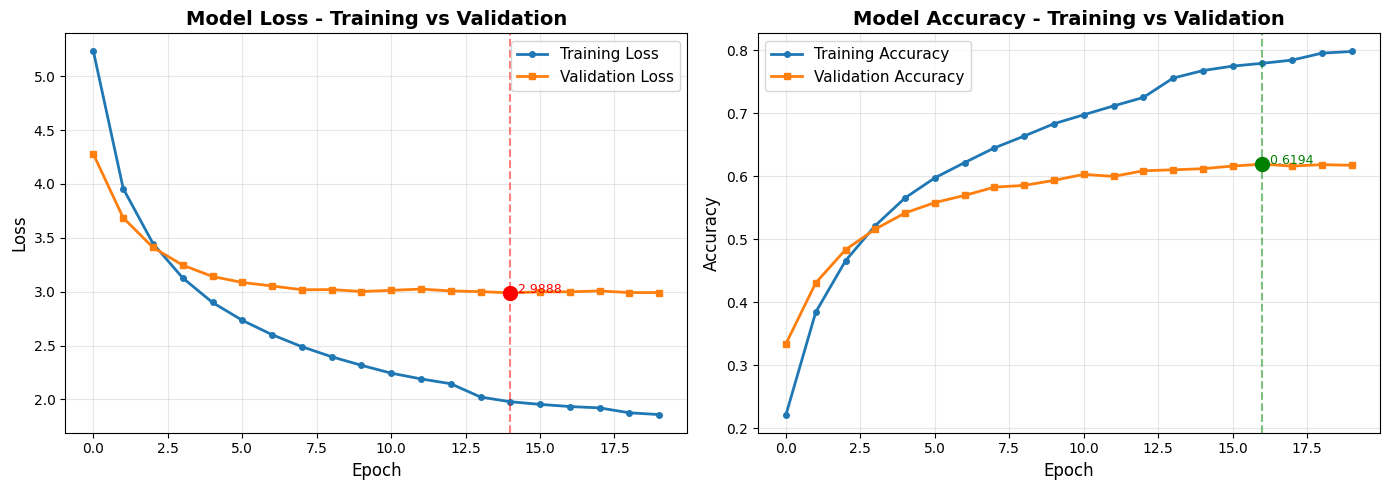

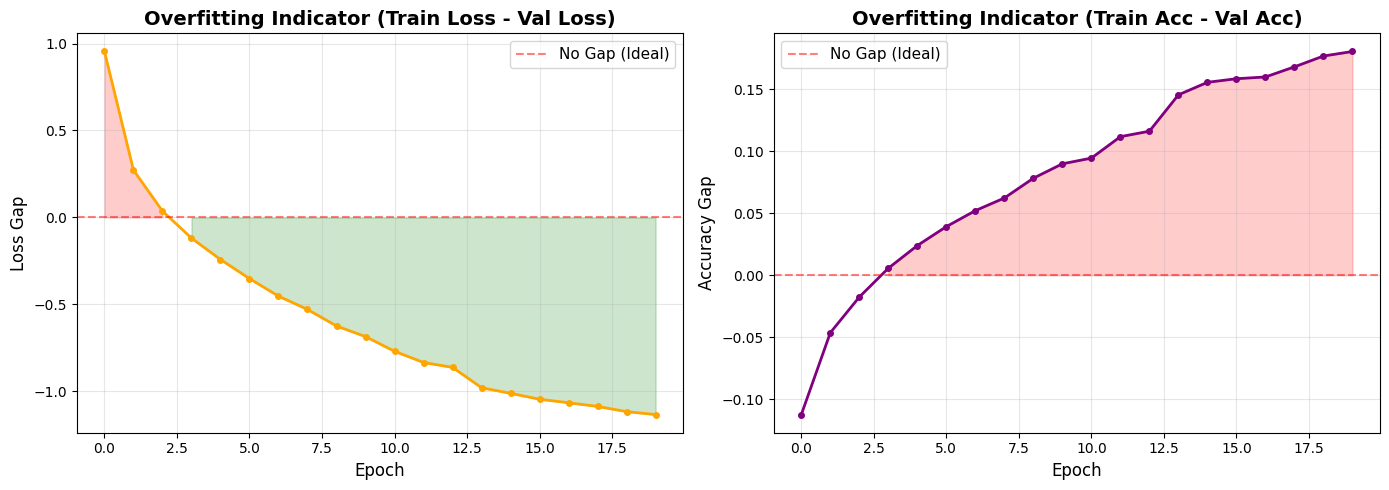


RINGKASAN HASIL TRAINING MODEL perbaikan

📊 LOSS:
  • Training Loss (Awal):    5.2304
  • Training Loss (Akhir):   1.8586
  • Validation Loss (Awal):  4.2763
  • Validation Loss (Akhir): 2.9918
  • Best Validation Loss:    2.9888 (Epoch 15)

🎯 ACCURACY:
  • Training Accuracy (Awal):    0.2220
  • Training Accuracy (Akhir):   0.7982
  • Validation Accuracy (Awal):  0.3346
  • Validation Accuracy (Akhir): 0.6176
  • Best Validation Accuracy:    0.6194 (Epoch 17)

📈 IMPROVEMENT:
  • Training Loss menurun:       64.46%
  • Validation Loss menurun:     30.04%
  • Training Accuracy meningkat: 259.49%
  • Validation Accuracy meningkat: 84.59%

⚠️  OVERFITTING CHECK:
  • Loss Gap (Akhir): -1.1331 - ⚠️  Kemungkinan UNDERFITTING
  • Accuracy Gap (Akhir): 0.1806 - ⚠️  Kemungkinan OVERFITTING

⏱️  TRAINING INFO:
  • Total Epochs Trained: 20
  • Batch Size: 32
  • Dataset Size: Train=5140, Val=643

Siap untuk evaluasi ROUGE pada test set!



In [50]:
# ============================================
# VISUALISASI HASIL TRAINING MODEL BASELINE
# ============================================

print("=== Membuat Visualisasi Hasil Training ===\n")

# Deteksi nama key metrik accuracy secara otomatis
accuracy_keys = [k for k in history.history.keys() if 'accuracy' in k.lower() and 'val' not in k]
val_accuracy_keys = [k for k in history.history.keys() if 'accuracy' in k.lower() and 'val' in k]

# Ambil key pertama yang ditemukan
train_acc_key = accuracy_keys[0] if accuracy_keys else None
val_acc_key = val_accuracy_keys[0] if val_accuracy_keys else None

print(f"Training Accuracy Key: {train_acc_key}")
print(f"Validation Accuracy Key: {val_acc_key}\n")

# --- 1. Plot Loss (Training vs Validation) ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
plt.title('Model Loss - Training vs Validation', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Tambahkan anotasi nilai terbaik
best_val_loss_epoch = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_epoch]
plt.axvline(x=best_val_loss_epoch, color='red', linestyle='--', alpha=0.5)
plt.scatter([best_val_loss_epoch], [best_val_loss], color='red', s=100, zorder=5)
plt.text(best_val_loss_epoch, best_val_loss, f'  {best_val_loss:.4f}', fontsize=9, color='red')

# --- 2. Plot Accuracy (Training vs Validation) ---
if train_acc_key and val_acc_key:
    plt.subplot(1, 2, 2)
    plt.plot(history.history[train_acc_key], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(history.history[val_acc_key], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    plt.title('Model Accuracy - Training vs Validation', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Tambahkan anotasi nilai terbaik
    best_val_acc_epoch = np.argmax(history.history[val_acc_key])
    best_val_acc = history.history[val_acc_key][best_val_acc_epoch]
    plt.axvline(x=best_val_acc_epoch, color='green', linestyle='--', alpha=0.5)
    plt.scatter([best_val_acc_epoch], [best_val_acc], color='green', s=100, zorder=5)
    plt.text(best_val_acc_epoch, best_val_acc, f'  {best_val_acc:.4f}', fontsize=9, color='green')

plt.tight_layout()
plt.show()

# --- 3. Plot Overfitting Analysis ---
if train_acc_key and val_acc_key:
    plt.figure(figsize=(14, 5))

    # Gap antara Training dan Validation Loss
    plt.subplot(1, 2, 1)
    loss_gap = np.array(history.history['loss']) - np.array(history.history['val_loss'])
    plt.plot(loss_gap, linewidth=2, marker='o', markersize=4, color='orange')
    plt.title('Overfitting Indicator (Train Loss - Val Loss)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Gap', fontsize=12)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap (Ideal)')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.fill_between(range(len(loss_gap)), loss_gap, 0, where=(loss_gap > 0), alpha=0.2, color='red')
    plt.fill_between(range(len(loss_gap)), loss_gap, 0, where=(loss_gap < 0), alpha=0.2, color='green')

    # Gap antara Training dan Validation Accuracy
    plt.subplot(1, 2, 2)
    acc_gap = np.array(history.history[train_acc_key]) - np.array(history.history[val_acc_key])
    plt.plot(acc_gap, linewidth=2, marker='o', markersize=4, color='purple')
    plt.title('Overfitting Indicator (Train Acc - Val Acc)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy Gap', fontsize=12)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Gap (Ideal)')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.fill_between(range(len(acc_gap)), acc_gap, 0, where=(acc_gap > 0), alpha=0.2, color='red')

    plt.tight_layout()
    plt.show()

# --- 4. Summary Statistics ---
print("\n" + "="*60)
print("RINGKASAN HASIL TRAINING MODEL perbaikan")
print("="*60)

print(f"\n📊 LOSS:")
print(f"  • Training Loss (Awal):    {history.history['loss'][0]:.4f}")
print(f"  • Training Loss (Akhir):   {history.history['loss'][-1]:.4f}")
print(f"  • Validation Loss (Awal):  {history.history['val_loss'][0]:.4f}")
print(f"  • Validation Loss (Akhir): {history.history['val_loss'][-1]:.4f}")
print(f"  • Best Validation Loss:    {best_val_loss:.4f} (Epoch {best_val_loss_epoch + 1})")

if train_acc_key and val_acc_key:
    print(f"\n🎯 ACCURACY:")
    print(f"  • Training Accuracy (Awal):    {history.history[train_acc_key][0]:.4f}")
    print(f"  • Training Accuracy (Akhir):   {history.history[train_acc_key][-1]:.4f}")
    print(f"  • Validation Accuracy (Awal):  {history.history[val_acc_key][0]:.4f}")
    print(f"  • Validation Accuracy (Akhir): {history.history[val_acc_key][-1]:.4f}")
    print(f"  • Best Validation Accuracy:    {best_val_acc:.4f} (Epoch {best_val_acc_epoch + 1})")

    print(f"\n📈 IMPROVEMENT:")
    train_loss_improvement = ((history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0]) * 100
    val_loss_improvement = ((history.history['val_loss'][0] - history.history['val_loss'][-1]) / history.history['val_loss'][0]) * 100
    train_acc_improvement = ((history.history[train_acc_key][-1] - history.history[train_acc_key][0]) / history.history[train_acc_key][0]) * 100
    val_acc_improvement = ((history.history[val_acc_key][-1] - history.history[val_acc_key][0]) / history.history[val_acc_key][0]) * 100

    print(f"  • Training Loss menurun:       {train_loss_improvement:.2f}%")
    print(f"  • Validation Loss menurun:     {val_loss_improvement:.2f}%")
    print(f"  • Training Accuracy meningkat: {train_acc_improvement:.2f}%")
    print(f"  • Validation Accuracy meningkat: {val_acc_improvement:.2f}%")

    print(f"\n⚠️  OVERFITTING CHECK:")
    final_loss_gap = history.history['loss'][-1] - history.history['val_loss'][-1]
    final_acc_gap = history.history[train_acc_key][-1] - history.history[val_acc_key][-1]

    if final_loss_gap > 0.1:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ⚠️  Kemungkinan OVERFITTING")
    elif final_loss_gap < -0.1:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ⚠️  Kemungkinan UNDERFITTING")
    else:
        print(f"  • Loss Gap (Akhir): {final_loss_gap:.4f} - ✅ Model BALANCED")

    if final_acc_gap > 0.05:
        print(f"  • Accuracy Gap (Akhir): {final_acc_gap:.4f} - ⚠️  Kemungkinan OVERFITTING")
    else:
        print(f"  • Accuracy Gap (Akhir): {final_acc_gap:.4f} - ✅ Model BALANCED")

print(f"\n⏱️  TRAINING INFO:")
print(f"  • Total Epochs Trained: {len(history.history['loss'])}")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Dataset Size: Train={len(encoder_input_train)}, Val={len(encoder_input_val)}")

print("\n" + "="*60)
print("Siap untuk evaluasi ROUGE pada test set!")
print("="*60 + "\n")

## Perbandingan hasil training dengan model baseline

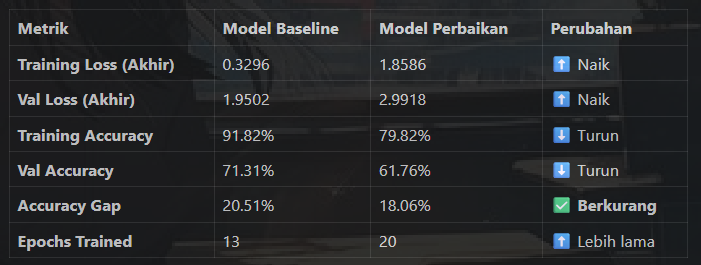

model ini masih overfitting, tapi lebih ringan

• Training Acc: 80% vs Val Acc: 62% (Gap: 18%)

• Loss Gap: -1.13 (UNDERFITTING di training?)

• Performa keseluruhan menurun

## **Evaluasi hasil perbaikan**

### kualitatif dengan rouge

### generate response baru

In [55]:
def generate_response_v2(question_text, max_length=MAX_LENGTH,
                         temperature=0.8, top_k=50, repetition_penalty=1.2):
    """
    Generation dengan:
    - Temperature sampling (bukan greedy)
    - Top-K filtering
    - Repetition penalty
    """
    question_clean = advanced_clean_text(question_text)
    input_text = f"{START_TOKEN} {question_clean} {END_TOKEN}"

    encoder_input = tokenizer([input_text])
    encoder_input = tf.cast(encoder_input, tf.int32)

    vocab = tokenizer.get_vocabulary()
    start_token_id = vocab.index(START_TOKEN) if START_TOKEN in vocab else 1
    end_token_id = vocab.index(END_TOKEN) if END_TOKEN in vocab else 2

    decoder_input = tf.constant([[start_token_id]], dtype=tf.int32)
    generated_tokens = []

    for i in range(max_length):
        predictions = transformer_model({
            "encoder_input": encoder_input,
            "decoder_input": decoder_input
        }, training=False)

        logits = predictions["final_output"][:, -1, :]  # (1, vocab_size)

        # ✅ 1. REPETITION PENALTY
        if len(generated_tokens) > 0:
            for token_id in set(generated_tokens[-10:]):  # Penalize 10 token terakhir
                if 0 <= token_id < logits.shape[-1]:
                    logits = tf.tensor_scatter_nd_update(
                        logits,
                        [[0, token_id]],
                        [logits[0, token_id] / repetition_penalty]
                    )

        # ✅ 2. TEMPERATURE SCALING
        logits = logits / temperature

        # ✅ 3. TOP-K FILTERING
        top_k_logits, top_k_indices = tf.nn.top_k(logits[0], k=top_k)

        # ✅ 4. SAMPLING (bukan argmax!)
        probabilities = tf.nn.softmax(top_k_logits)
        sampled_idx = tf.random.categorical(
            tf.math.log([probabilities]),
            num_samples=1,
            dtype=tf.int32
        )[0, 0]

        predicted_id = top_k_indices[sampled_idx].numpy()

        # Stop jika END token
        if predicted_id == end_token_id:
            break

        generated_tokens.append(predicted_id)

        # Update decoder input
        predicted_id_tensor = tf.constant([[predicted_id]], dtype=tf.int32)
        decoder_input = tf.concat([decoder_input, predicted_id_tensor], axis=-1)

    # Decode tokens
    response_text = []
    for token_id in generated_tokens:
        if 0 <= token_id < len(vocab):
            word = vocab[token_id]
            if word not in [START_TOKEN, END_TOKEN, '[UNK]', '', '[PAD]']:
                response_text.append(word)

    return ' '.join(response_text)

In [64]:
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd

print("="*70)
print("EVALUASI ROUGE - MODEL PERBAIKAN 1 (FIXED)")
print("="*70)

# ✅ CEK KETERSEDIAAN test_df
try:
    print(f"✅ test_df tersedia: {len(test_df)} rows")
    print(f"   Kolom: {test_df.columns.tolist()}")
except NameError:
    print("❌ ERROR: test_df tidak ditemukan!")
    print("⚠️  Jalankan cell 'REKONSTRUKSI test_df DARI SPLIT YANG ADA' terlebih dahulu!")
    raise

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

rouge_scores = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': []
}

num_test_samples = len(test_df)  # ✅ Gunakan test_df, bukan test_dataset!
num_eval_samples = min(200, num_test_samples)

print(f"\nTotal sampel test: {num_test_samples}")
print(f"Evaluasi {num_eval_samples} sampel pertama...\n")

success_count = 0
error_count = 0
error_details = []

# ✅ ITERASI LANGSUNG DI test_df (DataFrame)
for idx in range(num_eval_samples):
    try:
        # ✅ Akses DataFrame dengan .iloc[]
        question_original = test_df.iloc[idx]['question']
        reference = test_df.iloc[idx]['answer_clean']

        # Validasi data
        if pd.isna(question_original) or pd.isna(reference):
            error_count += 1
            error_details.append(f"Sampel {idx}: Data kosong/NaN")
            continue

        # Generate prediksi
        prediction = generate_response_v2(question_original)

        # Validasi prediksi
        if not prediction or len(prediction.strip()) == 0:
            error_count += 1
            error_details.append(f"Sampel {idx}: Prediksi kosong")
            continue

        # Hitung ROUGE
        scores = scorer.score(reference, prediction)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

        success_count += 1

        # Progress indicator dengan contoh
        if (idx + 1) % 50 == 0:
            print(f"✓ Progress: {idx + 1}/{num_eval_samples} sampel")
            print(f"  Contoh Q: {question_original[:60]}...")
            print(f"  Contoh P: {prediction[:60]}...")
            print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.4f}")

    except KeyError as e:
        error_count += 1
        error_details.append(f"Sampel {idx}: Kolom tidak ditemukan - {e}")
        if error_count <= 5:
            print(f"⚠ Error pada sampel {idx}: Kolom '{e}' tidak ada")
    except Exception as e:
        error_count += 1
        error_details.append(f"Sampel {idx}: {str(e)}")
        if error_count <= 5:
            print(f"⚠ Error pada sampel {idx}: {str(e)}")
        continue

# Hitung rata-rata ROUGE scores
print("\n" + "="*70)
print("HASIL EVALUASI ROUGE - MODEL PERBAIKAN 1")
print("="*70)

if success_count > 0:
    avg_rouge1 = np.mean(rouge_scores['rouge1'])
    avg_rouge2 = np.mean(rouge_scores['rouge2'])
    avg_rougeL = np.mean(rouge_scores['rougeL'])

    std_rouge1 = np.std(rouge_scores['rouge1'])
    std_rouge2 = np.std(rouge_scores['rouge2'])
    std_rougeL = np.std(rouge_scores['rougeL'])

    print(f"\n📊 ROUGE Scores (berdasarkan {success_count} sampel):")
    print(f"  • ROUGE-1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
    print(f"  • ROUGE-2: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
    print(f"  • ROUGE-L: {avg_rougeL:.4f} (±{std_rougeL:.4f})")

    print(f"\n📈 Interpretasi:")
    if avg_rouge1 > 0.7:
        print(f"  • ROUGE-1 ({avg_rouge1:.4f}): ⚠️ SANGAT TINGGI - Kemungkinan overfitting")
    elif avg_rouge1 > 0.5:
        print(f"  • ROUGE-1 ({avg_rouge1:.4f}): ✅ BAGUS - Model generalisasi baik")
    elif avg_rouge1 > 0.3:
        print(f"  • ROUGE-1 ({avg_rouge1:.4f}): ⚠️ CUKUP - Ada ruang improvement")
    else:
        print(f"  • ROUGE-1 ({avg_rouge1:.4f}): ❌ RENDAH - Model kesulitan")

    print(f"\n✓ Berhasil: {success_count} sampel")
    print(f"✗ Gagal: {error_count} sampel")

    # Simpan hasil
    rouge_perbaikan1 = {
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL,
        'success_count': success_count
    }
else:
    print("\n❌ Tidak ada sampel yang berhasil dievaluasi!")
    print(f"✗ Total error: {error_count} sampel")
    print(f"\n🔍 Detail error (5 pertama):")
    for detail in error_details[:5]:
        print(f"  • {detail}")

print("="*70)

EVALUASI ROUGE - MODEL PERBAIKAN 1 (FIXED)
✅ test_df tersedia: 643 rows
   Kolom: ['question', 'answer', 'question_clean', 'answer_clean', 'encoder_input_text', 'decoder_input_text', 'decoder_target_text']

Total sampel test: 643
Evaluasi 200 sampel pertama...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_stack' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib

✓ Progress: 50/200 sampel
  Contoh Q: Gue lagi tertekan banget nih, tugas kuliah numpuk....
  Contoh P: coba bagi tugas jadi bagian kecilkecil biar lebih mudah diha...
  ROUGE-1: 0.0000
✓ Progress: 100/200 sampel
  Contoh Q: Aku akan coba itu. Terus, gimana dengan stress yang aku rasa...
  Contoh P: coba eksplorasi beberapa metode belajar sampai kamu nemu yan...
  ROUGE-1: 0.1667
✓ Progress: 150/200 sampel
  Contoh Q: Makasih ya dok, atas sarannya....
  Contoh P: seperti kirim email obrolan biar mereka bisa baca berpikir d...
  ROUGE-1: 0.0000
✓ Progress: 200/200 sampel
  Contoh Q: Kadang aku bingung, harus gimana lagi biar bisa bayar uang k...
  Contoh P: kalau kamu sopan jujur biasanya dosen bakal paham...
  ROUGE-1: 0.0000

HASIL EVALUASI ROUGE - MODEL PERBAIKAN 1

📊 ROUGE Scores (berdasarkan 200 sampel):
  • ROUGE-1: 0.1058 (±0.1291)
  • ROUGE-2: 0.0130 (±0.0834)
  • ROUGE-L: 0.0952 (±0.1224)

📈 Interpretasi:
  • ROUGE-1 (0.1058): ❌ RENDAH - Model kesulitan

✓ Berhasil: 200 sampel


## perbaikan final

In [69]:
NUM_LAYERS = 6       # ⬆️ Kapasitas cukup
D_MODEL = 256        # ⬆️ Embedding lebih kuat
DFF = 1024           # ⬆️ FFN lebih besar
NUM_HEADS = 8        # ✓ Tetap
DROPOUT_RATE = 0.2   # ⬇️ Turunkan dari 0.3 (lebih balanced)

BATCH_SIZE = 32      # ✓ Tetap
EPOCHS = 30          # ✓ Tetap (pakai early stopping)
LEARNING_RATE = 1e-3 # ⬆️ Kembali ke 1e-3 (lebih cepat belajar)

In [70]:
# ✅ ADAPT TOKENIZER HANYA DARI TRAINING DATA
from sklearn.model_selection import train_test_split

# Split data dulu
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Adapt tokenizer HANYA dari training
train_corpus = (
    df_train['encoder_input_text'].tolist() +
    df_train['decoder_input_text'].tolist() +
    df_train['decoder_target_text'].tolist()
)
tokenizer.adapt(train_corpus)

In [71]:
import tensorflow as tf
import keras_nlp
from tensorflow import keras

# Dapatkan ukuran kosakata (pastikan tokenizer sudah di-adapt)
vocab_size = tokenizer.vocabulary_size()

# --- 1. Tentukan Input untuk Model ---
encoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="encoder_input"
)
decoder_input = keras.layers.Input(
    shape=(None,),
    dtype="int64",
    name="decoder_input"
)

# --- 2. Bagian ENCODER ---
encoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True, # Otomatis menangani padding mask
    name="encoder_embedding"
)
encoder_embedded = encoder_embedding_layer(encoder_input)

encoder_stack = keras.Sequential(
    [
        keras_nlp.layers.TransformerEncoder(
            intermediate_dim=DFF,
            num_heads=NUM_HEADS,
            dropout=DROPOUT_RATE,
            name=f"transformer_encoder_layer_{i}"
        )
        for i in range(NUM_LAYERS) # Ulangi sebanyak NUM_LAYERS
    ],
    name="encoder_stack"
)
encoder_output = encoder_stack(encoder_embedded)

# --- 3. Bagian DECODER ---
decoder_embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=MAX_LENGTH,
    embedding_dim=D_MODEL,
    mask_zero=True,
    name="decoder_embedding"
)
decoder_embedded = decoder_embedding_layer(decoder_input)

decoder_layers = [
    keras_nlp.layers.TransformerDecoder(
        intermediate_dim=DFF,
        num_heads=NUM_HEADS,
        dropout=DROPOUT_RATE,
        name=f"transformer_decoder_layer_{i}"
    )
    for i in range(NUM_LAYERS)
]

decoder_output = decoder_embedded
for layer in decoder_layers:
    decoder_output = layer(
        decoder_sequence=decoder_output,
        encoder_sequence=encoder_output
    )

# --- 4. Lapisan Output Akhir (PERBAIKAN DI SINI) ---
# Hapus activation="softmax". Biarkan default (linear) agar mengeluarkan LOGITS.
final_output = keras.layers.Dense(
    vocab_size,
    name="final_output"
)(decoder_output)

# --- 5. Rakit Model ---
transformer_model = keras.Model(
    inputs={
        "encoder_input": encoder_input,
        "decoder_input": decoder_input
    },
    outputs={
        "final_output": final_output
    }
)

# Tampilkan ringkasan arsitektur
print("--- Arsitektur Model (Diperbaiki) ---")
transformer_model.summary()

--- Arsitektur Model (Diperbaiki) ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │    665,856 │ encoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │    665,856 │ decoder_input[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_stack       │ (None, None, 256) │  4,738,560 │ encoder_embeddin… │
│ (Sequential)        │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,053,440 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, None,      │    635,561 │ transformer_deco… │
│ (Dense)             │ 2473)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,026,473 (49.69 MB)

 Trainable params: 13,026,473 (49.69 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Ganti cell #VSC-b6cea14b (compile ulang)

# ✅ OPTIMIZER DENGAN GRADIENT CLIPPING
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-4,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# ✅ LOSS DENGAN LABEL SMOOTHING (VERSI DIPERBAIKI)
def masked_loss_with_smoothing(y_true, y_pred, smoothing=0.05):
    """Label smoothing dengan masking yang lebih robust"""

    # Get vocab size from y_pred shape
    vocab_size = tf.shape(y_pred)[-1]

    # Create mask (padding = 0)
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    # Convert y_true to one-hot
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=vocab_size)

    # Apply label smoothing
    confidence = 1.0 - smoothing
    low_confidence = smoothing / tf.cast(vocab_size - 1, tf.float32)

    # Smooth labels
    y_true_smooth = y_true_onehot * confidence + low_confidence

    # Compute categorical crossentropy
    loss_fn = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True,
        reduction='none'
    )

    # Calculate loss
    loss = loss_fn(y_true_smooth, y_pred)

    # Apply mask (ignore padding positions)
    loss = loss * mask

    # Return mean loss (over non-padding positions)
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-8)  # Add epsilon to avoid division by zero

# ✅ ACCURACY FUNCTION (sama seperti sebelumnya)
def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    correct_predictions = tf.cast(tf.equal(y_pred, y_true), tf.float32)
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)
    return tf.reduce_sum(correct_predictions * mask) / (tf.reduce_sum(mask) + 1e-8)

# Compile model
transformer_model.compile(
    optimizer=optimizer,
    loss={"final_output": masked_loss_with_smoothing},
    metrics={"final_output": masked_accuracy}
)

print("✅ Model compiled dengan label smoothing (fixed) dan gradient clipping")

✅ Model compiled dengan label smoothing (fixed) dan gradient clipping


In [73]:
# Ganti Cell #VSC-d20b1c2a (Training) dengan versi yang ada debug

print("="*60)
print("DEBUG DAN PERSIAPAN TRAINING")
print("="*60)

# 1. CEK APAKAH DATA SUDAH ADA
print("\n[1/5] Cek keberadaan data training...")
print(f"  encoder_input_train shape: {encoder_input_train.shape}")
print(f"  decoder_input_train shape: {decoder_input_train.shape}")
print(f"  decoder_target_train shape: {decoder_target_train.shape}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")

# 2. REBUILD DATASET DARI AWAL (CRITICAL!)
print("\n[2/5] Rebuild dataset dengan batch size baru...")

def format_dataset(enc_in, dec_in, dec_target):
    """Format function untuk tf.data.Dataset"""
    return (
        {"encoder_input": enc_in, "decoder_input": dec_in},
        {"final_output": dec_target}
    )

# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    encoder_input_train,
    decoder_input_train,
    decoder_target_train
))
train_dataset = train_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    encoder_input_val,
    decoder_input_val,
    decoder_target_val
))
val_dataset = val_dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print("  ✅ Dataset berhasil di-rebuild")

# 3. VERIFIKASI DATASET TIDAK KOSONG
print("\n[3/5] Verifikasi dataset...")
try:
    # Ambil satu batch untuk test
    for batch in train_dataset.take(1):
        inputs, targets = batch
        print(f"  Input keys: {inputs.keys()}")
        print(f"  encoder_input shape: {inputs['encoder_input'].shape}")
        print(f"  decoder_input shape: {inputs['decoder_input'].shape}")
        print(f"  Target keys: {targets.keys()}")
        print(f"  final_output shape: {targets['final_output'].shape}")
    print("  ✅ Dataset valid!")

    # Hitung jumlah batch
    train_steps = len(encoder_input_train) // BATCH_SIZE
    val_steps = len(encoder_input_val) // BATCH_SIZE
    print(f"\n  Train steps per epoch: {train_steps}")
    print(f"  Validation steps per epoch: {val_steps}")

except Exception as e:
    print(f"  ❌ ERROR saat verifikasi: {e}")
    print("  Dataset mungkin kosong atau format salah!")
    raise

# 4. SETUP CALLBACKS
print("\n[4/5] Setup callbacks...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_transformer_v3.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]
print("  ✅ Callbacks ready")

# 5. MULAI TRAINING
print("\n[5/5] Memulai training...")
print("="*60)

try:
    history_v3 = transformer_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )

    print("\n" + "="*60)
    print("✅ TRAINING SELESAI")
    print("="*60)


    # Simpan weights final
    transformer_model.save_weights('transformer_v3_final.weights.h5')
    print("Model weights tersimpan!")

except Exception as e:
    print("\n" + "="*60)
    print("❌ ERROR SAAT TRAINING")
    print("="*60)
    print(f"Error: {e}")
    print("\nTraceback lengkap:")
    import traceback
    traceback.print_exc()

DEBUG DAN PERSIAPAN TRAINING

[1/5] Cek keberadaan data training...
  encoder_input_train shape: (5140, 128)
  decoder_input_train shape: (5140, 128)
  decoder_target_train shape: (5140, 128)
  BATCH_SIZE: 32

[2/5] Rebuild dataset dengan batch size baru...
  ✅ Dataset berhasil di-rebuild

[3/5] Verifikasi dataset...
  Input keys: dict_keys(['encoder_input', 'decoder_input'])
  encoder_input shape: (32, 128)
  decoder_input shape: (32, 128)
  Target keys: dict_keys(['final_output'])
  final_output shape: (32, 128)
  ✅ Dataset valid!

  Train steps per epoch: 160
  Validation steps per epoch: 20

[4/5] Setup callbacks...
  ✅ Callbacks ready

[5/5] Memulai training...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_stack' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 5.6570 - masked_accuracy: 0.1686
Epoch 1: val_loss improved from inf to 3.82558, saving model to best_transformer_v3.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 611ms/step - loss: 5.6521 - masked_accuracy: 0.1690 - val_loss: 3.8256 - val_masked_accuracy: 0.3586 - learning_rate: 5.0000e-04
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 3.6742 - masked_accuracy: 0.3781
Epoch 2: val_loss improved from 3.82558 to 3.22717, saving model to best_transformer_v3.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - loss: 3.6729 - masked_accuracy: 0.3783 - val_loss: 3.2272 - val_masked_accuracy: 0.4559 - learning_rate: 5.0000e-04
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.0122 - masked_accuracy: 0.4836
Epoch 3: val_loss improved from 3.22717 to 2.91099, saving model to best_transformer_v3.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - loss: 3.0115 - masked_accuracy: 0.4837 - val_loss: 2.9110 - va

Traceback (most recent call last):
  File "/tmp/ipython-input-2003939992.py", line 113, in <cell line: 0>
    print(f"Total epochs: {len(history_v3.history_v3['loss'])}")
                               ^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'History' object has no attribute 'history_v3'. Did you mean: 'history'?


In [74]:
print(f"Total epochs: {len(history_v3.history['loss'])}")
print(f"Best val_loss: {min(history_v3.history['val_loss']):.4f}")

Total epochs: 13
Best val_loss: 2.5618


VISUALISASI HASIL TRAINING - PERBAIKAN 2

📌 Metrik yang ditemukan:
  Training Accuracy Key:   masked_accuracy
  Validation Accuracy Key: val_masked_accuracy
  Available keys: ['loss', 'masked_accuracy', 'val_loss', 'val_masked_accuracy', 'learning_rate']



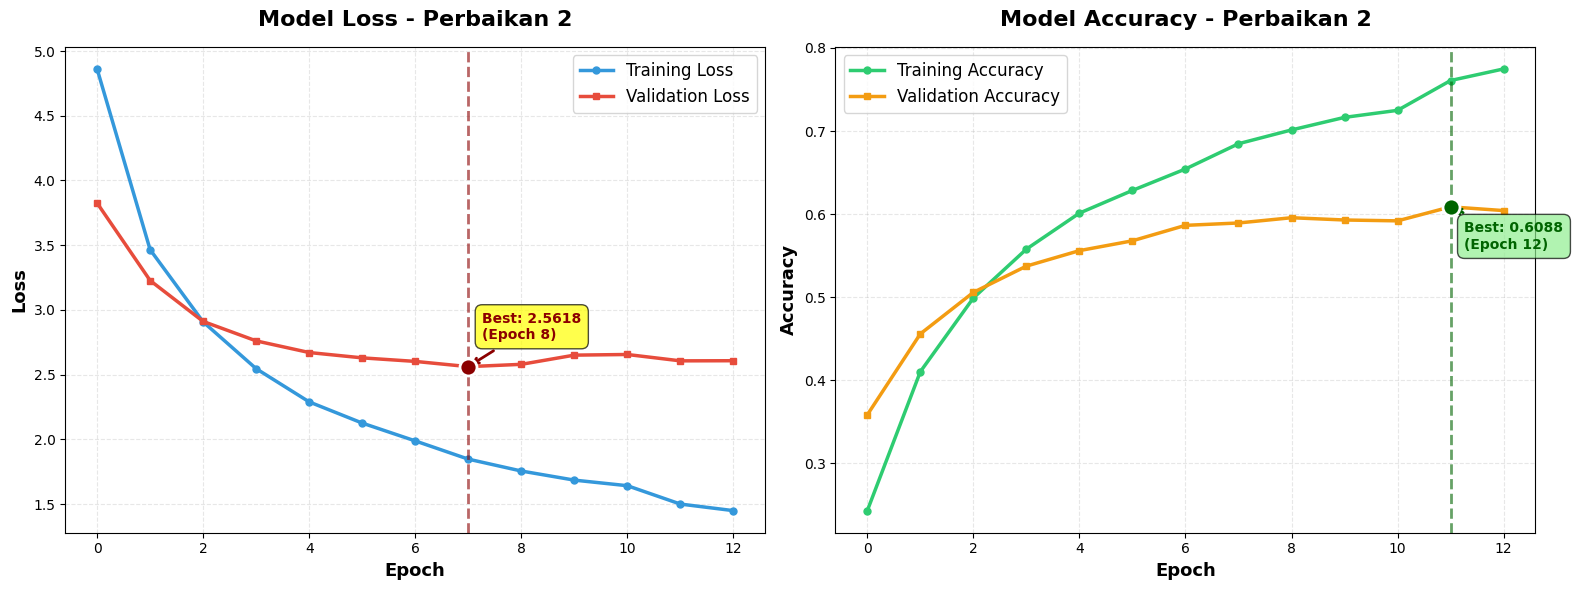

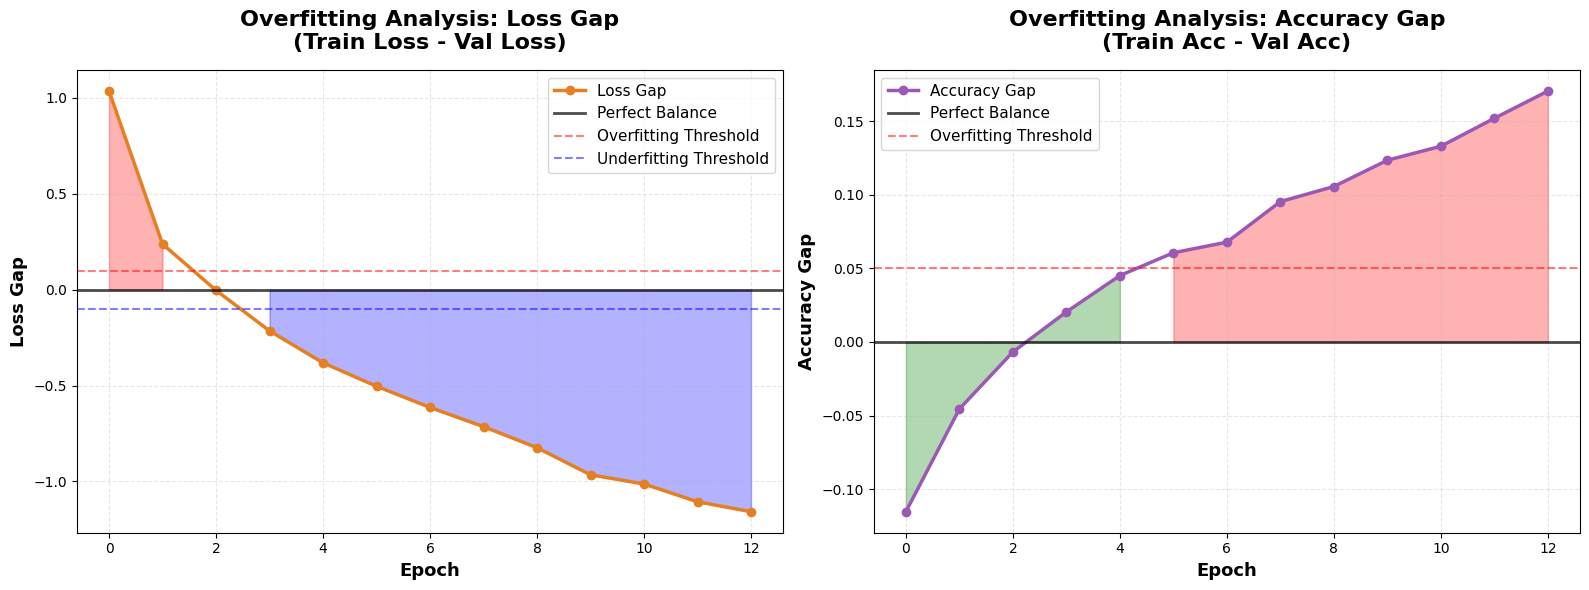


📊 RINGKASAN HASIL TRAINING - PERBAIKAN 2

🔥 LOSS METRICS:
  Training Loss:
    • Awal:        4.8617
    • Akhir:       1.4494
  Validation Loss:
    • Awal:        3.8256
    • Akhir:       2.6075
    • Best:        2.5618 (Epoch 8)

🎯 ACCURACY METRICS:
  Training Accuracy:
    • Awal:        0.2433
    • Akhir:       0.7748
  Validation Accuracy:
    • Awal:        0.3586
    • Akhir:       0.6043
    • Best:        0.6088 (Epoch 12)

📈 IMPROVEMENT FROM START TO END:
  • Training Loss ↓:       +70.19%
  • Validation Loss ↓:     +31.84%
  • Training Accuracy ↑:   +218.52%
  • Validation Accuracy ↑: +68.55%

⚖️  OVERFITTING ANALYSIS (Final Epoch):
  Loss Gap:      -1.1581 → ⚠️  UNDERFITTING terdeteksi!
  Accuracy Gap:  +0.1705 → ⚠️  OVERFITTING terdeteksi!

⏱️  TRAINING INFO:
  • Total Epochs:      13
  • Batch Size:        32
  • Learning Rate:     0.001
  • Dropout Rate:      0.2
  • Label Smoothing:   0.05
  • Model Capacity:    6 layers, 256 d_model, 1024 dff
  • Dataset Size:    

In [76]:
# ============================================
# VISUALISASI HASIL TRAINING - PERBAIKAN 2
# ============================================

print("="*70)
print("VISUALISASI HASIL TRAINING - PERBAIKAN 2")
print("="*70)

# --- CEK APAKAH HISTORY ADA ---
if 'history_v3' not in locals():
    print("\n❌ ERROR: history_v3 tidak ditemukan!")
    print("Pastikan Anda sudah menjalankan cell training terlebih dahulu.")
else:
    # Deteksi nama key metrik accuracy secara otomatis
    accuracy_keys = [k for k in history_v3.history.keys() if 'accuracy' in k.lower() and 'val' not in k]
    val_accuracy_keys = [k for k in history_v3.history.keys() if 'accuracy' in k.lower() and 'val' in k]

    # Ambil key pertama yang ditemukan
    train_acc_key = accuracy_keys[0] if accuracy_keys else None
    val_acc_key = val_accuracy_keys[0] if val_accuracy_keys else None

    print(f"\n📌 Metrik yang ditemukan:")
    print(f"  Training Accuracy Key:   {train_acc_key}")
    print(f"  Validation Accuracy Key: {val_acc_key}")
    print(f"  Available keys: {list(history_v3.history.keys())}\n")

    # --- 1. PLOT LOSS (TRAINING VS VALIDATION) ---
    fig = plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_v3.history['loss'], label='Training Loss',
             linewidth=2.5, marker='o', markersize=5, color='#3498db')
    plt.plot(history_v3.history['val_loss'], label='Validation Loss',
             linewidth=2.5, marker='s', markersize=5, color='#e74c3c')
    plt.title('Model Loss - Perbaikan 2', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=13, fontweight='bold')
    plt.ylabel('Loss', fontsize=13, fontweight='bold')
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')

    # Anotasi best val loss
    best_val_loss_epoch = np.argmin(history_v3.history['val_loss'])
    best_val_loss = history_v3.history['val_loss'][best_val_loss_epoch]
    plt.axvline(x=best_val_loss_epoch, color='darkred', linestyle='--', alpha=0.6, linewidth=2)
    plt.scatter([best_val_loss_epoch], [best_val_loss], color='darkred', s=150, zorder=5, edgecolors='white', linewidths=2)
    plt.annotate(f'Best: {best_val_loss:.4f}\n(Epoch {best_val_loss_epoch+1})',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(10, 20), textcoords='offset points',
                 fontsize=10, fontweight='bold', color='darkred',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

    # --- 2. PLOT ACCURACY (TRAINING VS VALIDATION) ---
    if train_acc_key and val_acc_key:
        plt.subplot(1, 2, 2)
        plt.plot(history_v3.history[train_acc_key], label='Training Accuracy',
                 linewidth=2.5, marker='o', markersize=5, color='#2ecc71')
        plt.plot(history_v3.history[val_acc_key], label='Validation Accuracy',
                 linewidth=2.5, marker='s', markersize=5, color='#f39c12')
        plt.title('Model Accuracy - Perbaikan 2', fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Epoch', fontsize=13, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
        plt.legend(fontsize=12, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')

        # Anotasi best val accuracy
        best_val_acc_epoch = np.argmax(history_v3.history[val_acc_key])
        best_val_acc = history_v3.history[val_acc_key][best_val_acc_epoch]
        plt.axvline(x=best_val_acc_epoch, color='darkgreen', linestyle='--', alpha=0.6, linewidth=2)
        plt.scatter([best_val_acc_epoch], [best_val_acc], color='darkgreen', s=150, zorder=5, edgecolors='white', linewidths=2)
        plt.annotate(f'Best: {best_val_acc:.4f}\n(Epoch {best_val_acc_epoch+1})',
                     xy=(best_val_acc_epoch, best_val_acc),
                     xytext=(10, -30), textcoords='offset points',
                     fontsize=10, fontweight='bold', color='darkgreen',
                     bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

    plt.tight_layout()
    plt.show()

    # --- 3. PLOT OVERFITTING ANALYSIS ---
    if train_acc_key and val_acc_key:
        fig = plt.figure(figsize=(16, 6))

        # Gap antara Training dan Validation Loss
        plt.subplot(1, 2, 1)
        loss_gap = np.array(history_v3.history['loss']) - np.array(history_v3.history['val_loss'])
        plt.plot(loss_gap, linewidth=2.5, marker='o', markersize=6, color='#e67e22', label='Loss Gap')
        plt.title('Overfitting Analysis: Loss Gap\n(Train Loss - Val Loss)', fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Epoch', fontsize=13, fontweight='bold')
        plt.ylabel('Loss Gap', fontsize=13, fontweight='bold')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2, label='Perfect Balance')
        plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Overfitting Threshold')
        plt.axhline(y=-0.1, color='blue', linestyle='--', alpha=0.5, linewidth=1.5, label='Underfitting Threshold')
        plt.legend(fontsize=11, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')

        # Color fill
        plt.fill_between(range(len(loss_gap)), loss_gap, 0,
                         where=(loss_gap > 0.1), alpha=0.3, color='red', label='Overfitting Zone')
        plt.fill_between(range(len(loss_gap)), loss_gap, 0,
                         where=(loss_gap < -0.1), alpha=0.3, color='blue', label='Underfitting Zone')
        plt.fill_between(range(len(loss_gap)), loss_gap, 0,
                         where=((loss_gap >= -0.1) & (loss_gap <= 0.1)), alpha=0.3, color='green')

        # Gap antara Training dan Validation Accuracy
        plt.subplot(1, 2, 2)
        acc_gap = np.array(history_v3.history[train_acc_key]) - np.array(history_v3.history[val_acc_key])
        plt.plot(acc_gap, linewidth=2.5, marker='o', markersize=6, color='#9b59b6', label='Accuracy Gap')
        plt.title('Overfitting Analysis: Accuracy Gap\n(Train Acc - Val Acc)', fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Epoch', fontsize=13, fontweight='bold')
        plt.ylabel('Accuracy Gap', fontsize=13, fontweight='bold')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2, label='Perfect Balance')
        plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Overfitting Threshold')
        plt.legend(fontsize=11, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')

        # Color fill
        plt.fill_between(range(len(acc_gap)), acc_gap, 0,
                         where=(acc_gap > 0.05), alpha=0.3, color='red')
        plt.fill_between(range(len(acc_gap)), acc_gap, 0,
                         where=(acc_gap <= 0.05), alpha=0.3, color='green')

        plt.tight_layout()
        plt.show()

    # --- 4. SUMMARY STATISTICS ---
    print("\n" + "="*70)
    print("📊 RINGKASAN HASIL TRAINING - PERBAIKAN 2")
    print("="*70)

    print(f"\n🔥 LOSS METRICS:")
    print(f"  Training Loss:")
    print(f"    • Awal:        {history_v3.history['loss'][0]:.4f}")
    print(f"    • Akhir:       {history_v3.history['loss'][-1]:.4f}")
    print(f"  Validation Loss:")
    print(f"    • Awal:        {history_v3.history['val_loss'][0]:.4f}")
    print(f"    • Akhir:       {history_v3.history['val_loss'][-1]:.4f}")
    print(f"    • Best:        {best_val_loss:.4f} (Epoch {best_val_loss_epoch + 1})")

    if train_acc_key and val_acc_key:
        print(f"\n🎯 ACCURACY METRICS:")
        print(f"  Training Accuracy:")
        print(f"    • Awal:        {history_v3.history[train_acc_key][0]:.4f}")
        print(f"    • Akhir:       {history_v3.history[train_acc_key][-1]:.4f}")
        print(f"  Validation Accuracy:")
        print(f"    • Awal:        {history_v3.history[val_acc_key][0]:.4f}")
        print(f"    • Akhir:       {history_v3.history[val_acc_key][-1]:.4f}")
        print(f"    • Best:        {best_val_acc:.4f} (Epoch {best_val_acc_epoch + 1})")

        print(f"\n📈 IMPROVEMENT FROM START TO END:")
        train_loss_improvement = ((history_v3.history['loss'][0] - history_v3.history['loss'][-1]) / history_v3.history['loss'][0]) * 100
        val_loss_improvement = ((history_v3.history['val_loss'][0] - history_v3.history['val_loss'][-1]) / history_v3.history['val_loss'][0]) * 100
        train_acc_improvement = ((history_v3.history[train_acc_key][-1] - history_v3.history[train_acc_key][0]) / (history_v3.history[train_acc_key][0] + 1e-8)) * 100
        val_acc_improvement = ((history_v3.history[val_acc_key][-1] - history_v3.history[val_acc_key][0]) / (history_v3.history[val_acc_key][0] + 1e-8)) * 100

        print(f"  • Training Loss ↓:       {train_loss_improvement:+.2f}%")
        print(f"  • Validation Loss ↓:     {val_loss_improvement:+.2f}%")
        print(f"  • Training Accuracy ↑:   {train_acc_improvement:+.2f}%")
        print(f"  • Validation Accuracy ↑: {val_acc_improvement:+.2f}%")

        print(f"\n⚖️  OVERFITTING ANALYSIS (Final Epoch):")
        final_loss_gap = history_v3.history['loss'][-1] - history_v3.history['val_loss'][-1]
        final_acc_gap = history_v3.history[train_acc_key][-1] - history_v3.history[val_acc_key][-1]

        print(f"  Loss Gap:      {final_loss_gap:+.4f}", end="")
        if final_loss_gap > 0.1:
            print(" → ⚠️  OVERFITTING terdeteksi!")
        elif final_loss_gap < -0.1:
            print(" → ⚠️  UNDERFITTING terdeteksi!")
        else:
            print(" → ✅ Model BALANCED!")

        print(f"  Accuracy Gap:  {final_acc_gap:+.4f}", end="")
        if final_acc_gap > 0.05:
            print(" → ⚠️  OVERFITTING terdeteksi!")
        else:
            print(" → ✅ Model BALANCED!")

    print(f"\n⏱️  TRAINING INFO:")
    print(f"  • Total Epochs:      {len(history_v3.history['loss'])}")
    print(f"  • Batch Size:        {BATCH_SIZE}")
    print(f"  • Learning Rate:     {LEARNING_RATE}")
    print(f"  • Dropout Rate:      {DROPOUT_RATE}")
    print(f"  • Label Smoothing:   0.05")
    print(f"  • Model Capacity:    {NUM_LAYERS} layers, {D_MODEL} d_model, {DFF} dff")
    print(f"  • Dataset Size:      Train={len(encoder_input_train)}, Val={len(encoder_input_val)}, Test={len(encoder_input_test)}")

    print("\n" + "="*70)
    print("✅ VISUALISASI SELESAI!")
    print("🚀 Siap untuk evaluasi ROUGE pada test set!")
    print("="*70 + "\n")

### Evaluasi

In [78]:
def generate_response_v2(question_text, max_length=MAX_LENGTH,
                         temperature=0.8, top_k=50, repetition_penalty=1.2):
    """
    Generation dengan:
    - Temperature sampling (bukan greedy)
    - Top-K filtering
    - Repetition penalty
    """
    question_clean = advanced_clean_text(question_text)
    input_text = f"{START_TOKEN} {question_clean} {END_TOKEN}"

    encoder_input = tokenizer([input_text])
    encoder_input = tf.cast(encoder_input, tf.int32)

    vocab = tokenizer.get_vocabulary()
    start_token_id = vocab.index(START_TOKEN) if START_TOKEN in vocab else 1
    end_token_id = vocab.index(END_TOKEN) if END_TOKEN in vocab else 2

    decoder_input = tf.constant([[start_token_id]], dtype=tf.int32)
    generated_tokens = []

    for i in range(max_length):
        predictions = transformer_model({
            "encoder_input": encoder_input,
            "decoder_input": decoder_input
        }, training=False)

        logits = predictions["final_output"][:, -1, :]  # (1, vocab_size)

        # ✅ 1. REPETITION PENALTY
        if len(generated_tokens) > 0:
            for token_id in set(generated_tokens[-10:]):  # Penalize 10 token terakhir
                if 0 <= token_id < logits.shape[-1]:
                    logits = tf.tensor_scatter_nd_update(
                        logits,
                        [[0, token_id]],
                        [logits[0, token_id] / repetition_penalty]
                    )

        # ✅ 2. TEMPERATURE SCALING
        logits = logits / temperature

        # ✅ 3. TOP-K FILTERING
        top_k_logits, top_k_indices = tf.nn.top_k(logits[0], k=top_k)

        # ✅ 4. SAMPLING (bukan argmax!)
        probabilities = tf.nn.softmax(top_k_logits)
        sampled_idx = tf.random.categorical(
            tf.math.log([probabilities]),
            num_samples=1,
            dtype=tf.int32
        )[0, 0]

        predicted_id = top_k_indices[sampled_idx].numpy()

        # Stop jika END token
        if predicted_id == end_token_id:
            break

        generated_tokens.append(predicted_id)

        # Update decoder input
        predicted_id_tensor = tf.constant([[predicted_id]], dtype=tf.int32)
        decoder_input = tf.concat([decoder_input, predicted_id_tensor], axis=-1)

    # Decode tokens
    response_text = []
    for token_id in generated_tokens:
        if 0 <= token_id < len(vocab):
            word = vocab[token_id]
            if word not in [START_TOKEN, END_TOKEN, '[UNK]', '', '[PAD]']:
                response_text.append(word)

    return ' '.join(response_text)

In [79]:
# ============================================
# EVALUASI ROUGE - PERBAIKAN FINAL
# ============================================

from rouge_score import rouge_scorer
import numpy as np

print("="*70)
print("EVALUASI ROUGE - PERBAIKAN FINAL")
print("="*70)

# Cek test_df
try:
    print(f"✅ test_df tersedia: {len(test_df)} rows")
except NameError:
    print("❌ ERROR: Jalankan cell rekonstruksi test_df terlebih dahulu!")
    raise

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

rouge_scores_final = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': []
}

num_eval_samples = min(200, len(test_df))
print(f"Evaluasi {num_eval_samples} sampel...\n")

success_count = 0
error_count = 0

for idx in range(num_eval_samples):
    try:
        question_original = test_df.iloc[idx]['question']
        reference = test_df.iloc[idx]['answer_clean']

        # Generate dengan model final
        prediction = generate_response_v2(
            question_original,
            temperature=0.7,      # Sedikit lebih rendah = lebih konservatif
            top_k=40,             # Lebih sedikit pilihan = lebih fokus
            repetition_penalty=1.3 # Lebih agresif anti-repetisi
        )

        if not prediction or len(prediction.strip()) == 0:
            error_count += 1
            continue

        # Hitung ROUGE
        scores = scorer.score(reference, prediction)
        rouge_scores_final['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores_final['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores_final['rougeL'].append(scores['rougeL'].fmeasure)

        success_count += 1

        if (idx + 1) % 50 == 0:
            print(f"✓ Progress: {idx + 1}/{num_eval_samples}")
            print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.4f}")

    except Exception as e:
        error_count += 1
        continue

# Hasil
print("\n" + "="*70)
print("HASIL ROUGE - PERBAIKAN FINAL")
print("="*70)

if success_count > 0:
    avg_rouge1 = np.mean(rouge_scores_final['rouge1'])
    avg_rouge2 = np.mean(rouge_scores_final['rouge2'])
    avg_rougeL = np.mean(rouge_scores_final['rougeL'])

    print(f"\n📊 ROUGE Scores ({success_count} sampel):")
    print(f"  • ROUGE-1: {avg_rouge1:.4f}")
    print(f"  • ROUGE-2: {avg_rouge2:.4f}")
    print(f"  • ROUGE-L: {avg_rougeL:.4f}")

    print(f"\n✓ Berhasil: {success_count}")
    print(f"✗ Gagal: {error_count}")

    # Simpan hasil
    rouge_final = {
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL,
        'success_count': success_count
    }
else:
    print("\n❌ Tidak ada sampel yang berhasil!")

print("="*70)

EVALUASI ROUGE - PERBAIKAN FINAL
✅ test_df tersedia: 643 rows
Evaluasi 200 sampel...

✓ Progress: 50/200
  ROUGE-1: 0.0000
✓ Progress: 100/200
  ROUGE-1: 0.2308
✓ Progress: 150/200
  ROUGE-1: 0.0000
✓ Progress: 200/200
  ROUGE-1: 0.2609

HASIL ROUGE - PERBAIKAN FINAL

📊 ROUGE Scores (200 sampel):
  • ROUGE-1: 0.0937
  • ROUGE-2: 0.0046
  • ROUGE-L: 0.0861

✓ Berhasil: 200
✗ Gagal: 0
